In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
# from Bio.SubsMat import MatrixInfo as matlist
import keras
from keras.layers import Dense, Embedding, Dropout, LSTM, Conv2D, Input, GRU
from keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Flatten, ZeroPadding1D
from keras.layers import SimpleRNN, Bidirectional, concatenate
from keras.models import Model
from keras import initializers
from scipy.stats import kendalltau, mode, spearmanr
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, roc_auc_score
import random
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
import os
from sklearn.metrics.pairwise import cosine_similarity
from keras.optimizers import Adam

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [2]:
cov_gexp_profiles = pd.read_csv('Data_for_ML/Coronavirus_infected_host_gene_expression/host_gexp.csv')

In [3]:
interactome = pd.read_csv('Data_for_ML/nCoV_host_interactome_entrez_ids.csv')

In [4]:
cov_gexp_profiles = cov_gexp_profiles.drop(['rid'],axis = 1)

In [5]:
rids = pd.read_csv('Data_for_ML/level5_1000.csv').rid

In [6]:
interactome_cov_gexp_profiles = pd.read_csv('Data_for_ML/Coronavirus_infected_host_gene_expression/host_gexp.csv')
indices_to_keep = interactome_cov_gexp_profiles['rid'].isin(list(interactome.GENE_ID))

In [7]:
interactome_cov_gexp_profiles = interactome_cov_gexp_profiles.loc[
    indices_to_keep
].reset_index(drop = True)




In [8]:
interactome_cov_gexp_profiles = interactome_cov_gexp_profiles.drop(['rid'], axis = 1)

In [9]:
interactome_cov_gexp_profiles.head()

,GSE68820_SARS_mouse_adapted_2dpi_log2_fc,GSE47960_BAT_24hr_log2_fc,GSE47960_SARS_24hr_log2_fc,GSE17400_SARS_24_hours_log2_fc,5_GSE147507_Series5_log2_fc,GSE100504_MERS_24hr_log2_fc,GSE47961_BAT_24hr_log2_fc,GSE47961_SARS_24hr_log2_fc,GSE56677_LoCovMERS_18hr_log2_fc,7_GSE147507_Series7_log2_fc,...,GSE86529_MERS_24hr_log2_fc,GSE108594_MERS_1e4_2dpi_log2_fc,GSE108594_MERS_1e5_2dpi_log2_fc,GSE108594_MERS_1e6_2dpi_log2_fc,GSE86528_MERS_24hr_log2_fc,15_GSE147507_Series15_log2_fc,GSE100496_MERS_24hr_log2_fc,GSE100509_MERS_24hr_log2_fc,GSE79458_MERS_24hr_log2_fc,16_GSE147507_Series16_log2_fc
0,-0.045070,-0.041735,-0.063861,-0.000323,0.119436,-0.070505,0.163924,-0.047153,-0.549065,-0.192093,...,-0.396865,-0.376939,-0.332280,-0.204117,-0.208788,1.287908,0.092821,-0.612733,-0.682893,-0.441409
1,-0.049164,-0.128339,-0.215626,0.010905,0.623270,-0.390893,-0.168798,-0.179763,-0.119630,0.464810,...,0.483670,0.009795,0.085761,0.080928,0.062165,-0.475416,-0.408972,0.841743,-0.041912,0.732235
2,0.973143,0.427588,0.518861,-0.019383,-0.488650,0.294212,-0.120544,-0.008071,-0.431039,1.667124,...,4.704538,0.468390,0.490625,0.385854,0.331905,-2.950339,0.300100,5.105798,1.043123,-0.235678
3,-0.268601,-0.067821,-0.101915,-0.047267,-0.106398,-0.174793,-0.024302,-0.013692,-0.243777,-0.203431,...,-0.052917,-0.149894,-0.257960,-0.259384,0.063495,0.180520,0.259406,-0.578849,0.297469,-0.161617
4,-0.098015,0.044136,0.183521,-0.179133,0.862686,0.246115,0.166479,0.045842,-0.730480,0.703781,...,-0.270729,0.104893,0.113681,0.047695,-0.173023,-2.973171,-0.108585,0.441159,-0.460739,0.674678


In [10]:
cols = []
for col in interactome_cov_gexp_profiles.columns:
    if 'GSE147507' in col and not '15' in col:
        cols.append(col)

In [11]:
cov2_gexp = interactome_cov_gexp_profiles[cols]

In [12]:
test_df = pd.read_pickle('Data_for_ML/Signature_splits/test_df.pkl')

In [13]:
train_df = pd.read_pickle('Data_for_ML/Signature_splits/train_df.pkl')

In [14]:
val_df = pd.read_pickle('Data_for_ML/Signature_splits/valid_df.pkl')

In [15]:
all_ref_df.head()

NameError: name 'all_ref_df' is not defined

In [16]:
# def rearrange_datasets(new_test_train_val_folder, old_sig_train_df, old_sig_val_df, old_sig_test_df,
#                        x_trains, x_vals, x_tests, merge_train_and_val = False):
#     new_train_df = pd.read_csv(new_test_train_val_folder + 'train_full.csv')
#     new_test_df = pd.read_csv(new_test_train_val_folder + 'test_full.csv')
#     new_val_df = pd.read_csv(new_test_train_val_folder + 'val_full.csv')
#     new_x_tests = [[] for _ in range(len(x_tests))]
#     new_x_tests = compile_split(new_test_df, old_sig_train_df, old_sig_val_df, old_sig_test_df,
#                        x_trains, x_vals, x_tests)
#     new_x_vals = compile_split(new_val_df, old_sig_train_df, old_sig_val_df, old_sig_test_df,
#                        x_trains, x_vals, x_tests)
#     new_x_trains = compile_split(new_train_df, old_sig_train_df, old_sig_val_df, old_sig_test_df,
#                        x_trains, x_vals, x_tests)
#     if merge_train_and_val:
#         all_x_trains = [new_x_trains[i]+new_x_vals[i] for i in range(len(x_trains))]
#         return all_x_trains, new_x_tests
#     return new_x_trains, new_x_vals, new_x_tests

# def rearrange_datasets(new_test_train_val_folder, old_sig_df,
#                        all_xs, merge_train_and_val = False):
#     new_train_df = pd.read_csv(new_test_train_val_folder + 'train_full.csv')
#     new_test_df = pd.read_csv(new_test_train_val_folder + 'test_full.csv')
#     new_val_df = pd.read_csv(new_test_train_val_folder + 'val_full.csv')
# #     new_x_tests = [[] for _ in range(len(all_xs))]
#     new_x_tests = compile_split(new_test_df, old_sig_df,
#                        all_xs)
#     new_x_vals = compile_split(new_val_df, old_sig_df,
#                        all_xs)
#     new_x_trains = compile_split(new_train_df, old_sig_df,
#                        all_xs)
#     if merge_train_and_val:
#         all_x_trains = [new_x_trains[i]+new_x_vals[i] for i in range(len(x_trains))]
#         return all_x_trains, new_x_tests
#     return new_x_trains, new_x_vals, new_x_tests

def rearrange_datasets(new_test_train_val_folder, old_sig_df,
                       all_xs, merge_train_and_val = False):
    new_train_df = pd.read_csv(new_test_train_val_folder + 'train_full.csv')
    new_test_df = pd.read_csv(new_test_train_val_folder + 'test_full.csv')
    new_val_df = pd.read_csv(new_test_train_val_folder + 'val_full.csv')
    new_x_trains = [[] for _ in range(len(all_xs))]
    new_x_vals = [[] for _ in range(len(all_xs))]
    new_x_tests = [[] for _ in range(len(all_xs))]
    print(len(new_x_trains))
    for i, row in old_sig_df.iterrows():
#         if abs(row.Inh_index - 0.119931)<0.0001:
#             print(row)
        placed = False
        for j, pertid_list in enumerate(new_train_df.pert_ID):
            if row.pert_id in pertid_list and not np.isnan(new_train_df.Touret_inh_index[j]):
                for k in range(len(all_xs)):
                    new_x_trains[k].append(all_xs[k][i])
                placed = True
#                 if abs(row.Inh_index - 0.119931)<0.0001:
#                     print('Placed in train')
        if not placed:
            for j, pertid_list in enumerate(new_val_df.pert_ID):
                if row.pert_id in pertid_list and not np.isnan(new_val_df.Touret_inh_index[j]):
                    for k in range(len(all_xs)):
                        new_x_vals[k].append(all_xs[k][i])
                    placed = True
#                     if abs(row.Inh_index - 0.119931)<0.0001:
#                         print('Placed in val')
        if not placed:
            for j, pertid_list in enumerate(new_test_df.pert_ID):
                if row.pert_id in pertid_list and not np.isnan(new_test_df.Touret_inh_index[j]):
                    for k in range(len(all_xs)):
                        new_x_tests[k].append(all_xs[k][i])
                    placed = True
#                     if abs(row.Inh_index - 0.119931)<0.0001:
#                         print('Placed in test')
#         if not placed:
#             print('NOT PLACED: ', row.pert_id) 
    if merge_train_and_val:
        all_x_trains = [new_x_trains[i]+new_x_vals[i] for i in range(len(all_xs))]
        return all_x_trains, new_x_tests
    return new_x_trains, new_x_vals, new_x_tests

def compile_split(new_df, old_sig_df, all_xs):
    new_xs = [[] for _ in range(len(all_xs))]
    add_to_split(new_xs, new_df, old_sig_df, all_xs)
    return new_xs

def add_to_split(new_xs, new_df, old_df, old_xs):
#     for x in old_xs:
#         print(len(x))
    for j, new_pertids in enumerate(new_df.pert_ID):
        for i, pert_id in enumerate(old_df.pert_id):
#             print(new_row)
            if pert_id in new_pertids and not np.isnan(new_df.Touret_inh_index[j]):
#                 counter += 1
                for j in range(len(old_xs)):
                    new_xs[j].append(old_xs[j][i])

In [22]:
# all_ref_df = pd.concat([train_df, val_df, test_df], ignore_index = True)
# all_x = [np.concatenate((x_train, x_val, x_test)),
#         np.concatenate((x_train_for_cos, x_val_for_cos, x_test_for_cos)),
#         np.concatenate((x_train_comp_to_cov_norm, x_val_comp_to_cov_norm, x_test_comp_to_cov_norm)),
#         np.concatenate((y_train, y_val, y_test))]

NameError: name 'x_train_for_cos' is not defined

In [18]:
test_pert_df = pd.read_csv('Data_for_ML/Scaffold_split_activity_data/test_full.csv').drop_duplicates().reset_index(drop = True)
train_pert_df = pd.read_csv('Data_for_ML/Scaffold_split_activity_data/train_full.csv').drop_duplicates().reset_index(drop = True)
val_pert_df = pd.read_csv('Data_for_ML/Scaffold_split_activity_data/val_full.csv').drop_duplicates().reset_index(drop = True)

In [19]:
x_train = np.array(train_df.gexp)
x_train = np.array([np.array(x) for x in x_train])
y_train = train_df.Inh_index
train_weights = [1.0/train_df.Inh_index.value_counts()[inh] for inh in train_df.Inh_index]
x_val = np.array(val_df.gexp)
x_val = np.array([np.array(x) for x in x_val])
y_val = val_df.Inh_index
val_weights = [1.0/val_df.Inh_index.value_counts()[inh] for inh in val_df.Inh_index]
x_test = np.array(test_df.gexp)
x_test = np.array([np.array(x) for x in x_test])
y_test = test_df.Inh_index
test_weights = [1.0/test_df.Inh_index.value_counts()[inh] for inh in test_df.Inh_index]
all_cell_ids = list(train_df.cell_id) + list(val_df.cell_id) + list(test_df.cell_id)
all_one_hot = pd.get_dummies(all_cell_ids)
x_train_dose = np.log1p(train_df.pert_dose)
x_val_dose = np.log1p(val_df.pert_dose)
x_test_dose = np.log1p(test_df.pert_dose)

In [20]:
x_train_cell = all_one_hot[0:len(x_train)].reset_index(drop = True)
x_val_cell = all_one_hot[len(x_train):(len(x_train)+len(x_val))].reset_index(drop = True)
x_test_cell = all_one_hot[(len(x_train)+len(x_val)):].reset_index (drop = True)

In [21]:
x_test_cell.head()

,A375,A549,A673,AGS,ASC,BT20,CD34,CL34,CORL23,COV644,...,SW480,SW620,SW948,T3M10,THP1,TYKNU,U266,U937,VCAP,WSUDLCL2
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# import csv
x_test_for_cos = []
for j, x in enumerate(x_test):
    if j%1000 == 5:
        print(j)
    x_test_for_cos.append([x[i] for i in range(len(x)) if indices_to_keep[i]])
    
x_val_for_cos = []
for j, x in enumerate(x_val):
    if j%1000 == 5:
        print(j)
    x_val_for_cos.append([x[i] for i in range(len(x)) if indices_to_keep[i]])
    
x_train_for_cos = []
for j, x in enumerate(x_train):
    if j%1000 == 5:
        print(j)
    x_train_for_cos.append([x[i] for i in range(len(x)) if indices_to_keep[i]])
    
# with open("Data_for_ML/Feature_variables/x_val_for_cos.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_val_for_cos)
# with open("Data_for_ML/Feature_variables/x_test_for_cos.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_test_for_cos)
# with open("Data_for_ML/Feature_variables/x_train_for_cos.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_train_for_cos)

In [23]:
# import csv
# x_test_for_cos = list(csv.reader(open('Data_for_ML/Feature_variables/x_test_for_cos.csv')))
# x_val_for_cos = list(csv.reader(open('Data_for_ML/Feature_variables/x_val_for_cos.csv')))
# x_train_for_cos = list(csv.reader(open('Data_for_ML/Feature_variables/x_train_for_cos.csv')))

In [24]:
x_test_for_cos = [[float(val) for val in inner] for inner in x_test_for_cos]
x_train_for_cos = [[float(val) for val in inner] for inner in x_train_for_cos]
x_val_for_cos = [[float(val) for val in inner] for inner in x_val_for_cos]

In [25]:
def cos_similarity_with_na(list1, list2, use_abs = False):
    dot = 0
    ss1 = 0
    ss2 = 0
    for i in range(len(list1)):
        val1 = list1[i]
        val2 = list2[i]
        if use_abs:
            val1 = abs(val1)
            val2 = abs(val2)
        if not (np.isnan(val1) or np.isnan(val2)):
            ss1 += val1*val1
            ss2 += val2*val2
            dot += val1*val2
    return dot/(np.sqrt(ss1)*np.sqrt(ss2))

In [26]:
norm_cov2_gexp = (cov2_gexp-cov2_gexp.mean())/cov2_gexp.std()


In [27]:
def get_cosines(x_dset, cov_dset, intervals = 2000, use_abs = False):
    to_return = [[] for _ in x_dset]
    for i in range(len(x_dset)):
        to_return[i] = [
            cos_similarity_with_na(x_dset[i], cov_dset[name], use_abs = use_abs) for name in list(cov_dset.columns)
        ]
        if i%intervals == 5:
            print(i)
#     print(len(to_return))
    return to_return
def get_normalized_2d_list(dset):
    stds = [np.std(xvec) for xvec in dset]
    means = [np.mean(xvec) for xvec in dset]
    to_return = []
    for i, xvec in enumerate(dset):
        if i%2000 == 5:
            print(i)
        to_return.append([(x-means[i])/stds[i] for x in xvec])
    return to_return

In [28]:
norm_x_test_for_cos = get_normalized_2d_list(x_test_for_cos)
norm_x_train_for_cos = get_normalized_2d_list(x_train_for_cos)
norm_x_val_for_cos = get_normalized_2d_list(x_val_for_cos)
# norm_cov_gexp = (interactome_cov_gexp_profiles-interactome_cov_gexp_profiles.mean())/interactome_cov_gexp_profiles.std()


5
2005
4005
5
2005
4005
6005
8005
10005
12005
14005
16005
18005
5
2005
4005
6005


In [29]:
x_test_cosine = get_cosines(norm_x_test_for_cos, norm_cov2_gexp)
x_val_cosine = get_cosines(norm_x_val_for_cos, norm_cov2_gexp)
x_train_cosine = get_cosines(norm_x_train_for_cos, norm_cov2_gexp)

5
2005
4005
5
2005
4005
6005
5
2005
4005
6005
8005
10005
12005
14005
16005
18005


In [30]:
x_test_cosine_abs = get_cosines(norm_x_test_for_cos, norm_cov2_gexp, use_abs = True)
x_val_cosine_abs = get_cosines(norm_x_val_for_cos, norm_cov2_gexp, use_abs = True)
x_train_cosine_abs = get_cosines(norm_x_train_for_cos, norm_cov2_gexp, use_abs = True)

5
2005
4005
5
2005
4005
6005
5
2005
4005
6005
8005
10005
12005
14005
16005
18005


In [31]:
print(norm_cov2_gexp.columns)

Index(['5_GSE147507_Series5_log2_fc', '7_GSE147507_Series7_log2_fc',
       '6_GSE147507_Series6_log2_fc', '2_GSE147507_Series2_log2_fc',
       '1_GSE147507_Series1_log2_fc', '16_GSE147507_Series16_log2_fc'],
      dtype='object')


In [32]:
# print(np.mean(norm_cov_gexp['GSE68820_SARS_mouse_adapted_2dpi_log2_fc']))
# print(np.std(norm_cov_gexp['GSE68820_SARS_mouse_adapted_2dpi_log2_fc']))
# print(np.mean(interactome_cov_gexp_profiles['GSE68820_SARS_mouse_adapted_2dpi_log2_fc']))
# print(np.std(interactome_cov_gexp_profiles['GSE68820_SARS_mouse_adapted_2dpi_log2_fc']))

NameError: name 'norm_cov_gexp' is not defined

In [33]:
def get_comp_to_cov(x_matrix, cov_df):
    to_return = [[] for _ in x_matrix]
    for i,x in enumerate(x_matrix):
        for col in cov_df.columns:
            to_return[i].append([x[j]-cov_df[col][j] for j in range(len(x))])
        if i%2000 == 5:
            print(i)
    return to_return

In [37]:
print(len(x_test_comp_to_cov_norm))
print(len(x_test_comp_to_cov_norm[0]))
print(len(x_test_comp_to_cov_norm[0][0]))

5581
6
278


In [38]:
# Try using all-positive thing
print(len(x_test_comp_to_cov_norm))
print(len(x_test_comp_to_cov_norm[0]))
print(len(x_test_comp_to_cov_norm[0][0]))

5581
6
278


In [35]:
x_test_comp_to_cov_norm = get_comp_to_cov(norm_x_test_for_cos, norm_cov2_gexp)

5
2005
4005


In [36]:
x_val_comp_to_cov_norm = get_comp_to_cov(norm_x_val_for_cos, norm_cov2_gexp)
x_train_comp_to_cov_norm = get_comp_to_cov(norm_x_train_for_cos, norm_cov2_gexp)

5
2005
4005
6005
5
2005
4005
6005
8005
10005
12005
14005
16005
18005


In [133]:
# x_test_comp_to_cov = x_test_comp_to_cov_norm
# x_val_comp_to_cov = x_val_comp_to_cov_norm
# x_train_comp_to_cov = x_train_comp_to_cov_norm

KeyboardInterrupt: 

In [31]:
# with open("Data_for_ML/Feature_variables/x_test_comp_to_cov.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_test_comp_to_cov)

In [39]:
def nan_to_zero(list_with_nans):
    for i, xvec in enumerate(list_with_nans):
        if i%2000 == 5:
            print(i)
        for j, xvec2 in enumerate(xvec):
            for k, x in enumerate(xvec2):
                if np.isnan(x):
                    list_with_nans[i][j][k] = 0

In [40]:
nan_to_zero(x_test_comp_to_cov_norm)

5
2005
4005


In [41]:
nan_to_zero(x_val_comp_to_cov_norm)

5
2005
4005
6005


In [42]:
nan_to_zero(x_train_comp_to_cov_norm)

5
2005
4005
6005
8005
10005
12005
14005
16005
18005


In [43]:
np.std(x_train_comp_to_cov_norm[8:20])

1.3826673600943453

In [155]:
np.std(x_train_comp_to_cov_norm[8:20])

1.419443887720422

In [34]:
# with open("Data_for_ML/Feature_variables/x_val_comp_to_cov.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_val_comp_to_cov)

In [35]:
# with open("Data_for_ML/Feature_variables/x_train_comp_to_cov.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(x_train_comp_to_cov)

In [44]:
def dense_regression_model(n_big_layers=2,layer_size=100,dropout=0.1,input_dim=12328):
    model = keras.models.Sequential()
    model.add(Dense(layer_size,activation='relu',input_dim=input_dim))
    model.add(Dropout(dropout))
    for i in range(n_big_layers-1):
        model.add(Dense(layer_size,activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def dense_model_api():
    gexp_input = Input(shape = (12328,))
    gexp_layer = Dense(100, activation = 'relu')(gexp_input)
    dropout_layer = Dropout(0.1)(gexp_layer)
    gexp_layer = Dense(100, activation = 'relu')(dropout_layer)
    dropout_layer = Dropout(0.1)(gexp_layer)
    gexp_layer = Dense(20, activation = 'relu')(dropout_layer)
    output_layer = Dense(1)(gexp_layer)
    gexp_model = Model(inputs = gexp_input, outputs = output_layer)
    gexp_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return gexp_model


def dense_regression_model_with_cos_similarity_and_cell_id(dropout = 0.1, gexp_input_dim = 12328, cosine_input_dim = 31,
                                             n_cell_lines = 70, dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    cosine_input = Input(shape = (cosine_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    cell_input = Input(shape = (n_cell_lines,))
    
#     First branch on formulation input
    cosine_layer = Dense(cosine_input_dim)(cosine_input)
    if cosine_layers > 1:
        for i in range(cosine_layers-1):
            cosine_layer = Dense(cosine_input_dim, activation = 'relu')(cosine_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)

# Third branch on cell ID input
    cell_layer = Dense(n_cell_lines)(cell_input)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([cosine_layer, gexp_layer, cell_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, cosine_input, cell_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model


def dense_regression_model_with_dose_and_cell_id(dropout = 0.1, gexp_input_dim = 12328, dose_input_dim = 1,
                                             n_cell_lines = 70, dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    dose_input = Input(shape = (dose_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    cell_input = Input(shape = (n_cell_lines,))
    
#     First branch on formulation input
    dose_layer = Dense(dose_input_dim)(dose_input)
    if dose_layers > 1:
        for i in range(dose_layers-1):
            dose_layer = Dense(dose_input_dim, activation = 'relu')(dose_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)

# Third branch on cell ID input
    cell_layer = Dense(n_cell_lines)(cell_input)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([gexp_layer, cell_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, dose_input, cell_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def dense_regression_model_with_dose(dropout = 0.1, gexp_input_dim = 12328, dose_input_dim = 1,
                                             dose_layers = 1, gexp_layer_size = 100, concat_layer_size = 100,
                                            gexp_layers = 1, post_concat_layers = 2):
#     Define inputs
    dose_input = Input(shape = (dose_input_dim,))
    gexp_input = Input(shape = (gexp_input_dim,))
    
#     First branch on formulation input
    dose_layer = Dense(dose_input_dim)(dose_input)
    if dose_layers > 1:
        for i in range(dose_layers-1):
            dose_layer = Dense(dose_input_dim, activation = 'relu')(dose_layer)
#     dose_model = Model(inputs = dose_input, outputs = dose_layer)
    
#     Second branch on structure input
    gexp_layer = Dense(gexp_layer_size)(gexp_input)
    if gexp_layers > 1:
        for i in range(gexp_layers-1):
            gexp_layer = Dense(gexp_layer_size, activation = 'relu')(gexp_layer)
#     gexp_model = Model(inputs = gexp_input, outputs = gexp_layer)
    
#     Concatenate and put on the finishing touches
    combined = concatenate([dose_layer, gexp_layer])
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'relu')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(20, activation = 'relu')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = [gexp_input, dose_input], outputs = final_output)
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

def all_dense_model(dropout = 0.4, gexp_input_dim = 12328, cos_input_dim = 6, cos_layer_size = 6, dose_input_dim = 1,
                         cell_input_dim = 70, gexp_comp_input_dim_1 = 6, gexp_comp_input_dim_2 = 278,
                    dose_layers = 1, cell_layers = 1, gexp_layers = 1, cos_layers = 1, gexp_comp_layers = 1,
                          post_concat_layers = 2, gexp_layer_size = 100, cell_layer_size = 30,
                    concat_layer_size = 100, gexp_comp_layer_size = 100, gexp_comp_filters = 100,
                         use_gexp = True, use_cos = False, use_cell = True, use_dose = False, use_gexp_comp = True):
    layers_to_merge = []
    input_layers = []
#     Gene expression branch
    if use_gexp:
        gexp_input = Input(shape = (gexp_input_dim,))
        gexp_layer = Dense(gexp_layer_size)(gexp_input)
        if gexp_layers > 1:
            for i in range(gexp_layers-1):
                gexp_layer = Dense(gexp_layer_size, activation = 'swish')(gexp_layer)
        layers_to_merge.append(gexp_layer)
        input_layers.append(gexp_input)
# Cosine similarity branch
    if use_cos:
        cosine_input = Input(shape = (cos_input_dim,))
        cosine_layer = Dense(cos_layer_size)(cosine_input)
        if cos_layers > 1:
            for i in range(cos_layers-1):
                cosine_layer = Dense(cos_layer_size, activation = 'swish')(cosine_layer)
        layers_to_merge.append(cosine_layer)
        input_layers.append(cosine_input)
# Gene expression comparison branch
    if use_gexp_comp:
        gexp_comp_input = Input(shape = (gexp_comp_input_dim_1,gexp_comp_input_dim_2,))
#         conv_layer = Conv1D(gexp_comp_filters, kernel_size = gexp_comp_input_dim_2,
#                             padding = 'valid', data_format = 'channels_first')(gexp_comp_input)
        flatten_layer = Flatten()(gexp_comp_input)
        gexp_comp_layer = Dense(gexp_comp_layer_size)(flatten_layer)
        if gexp_comp_layers > 1:
            for i in range(gexp_comp_layers-1):
                gexp_comp_layer = Dense(gexp_comp_layer_size, activation = 'swish')(gexp_comp_layer)
        layers_to_merge.append(gexp_comp_layer)
        input_layers.append(gexp_comp_input)
# Dose branch
    if use_dose:
        dose_input = Input(shape = (dose_input_dim,))
        dose_layer = Dense(dose_layer_size)(dose_layer)
        if dose_layers > 1:
            for i in range(dose_layers-1):
                dose_layer = Dense(dose_layer_size, activation = 'swish')(dose_layer)
        layers_to_merge.append(dose_layer)
        input_layers.append(dose_input)
# Cell line branch
    if use_cell:
        cell_input = Input(shape = (cell_input_dim,))
        cell_layer = Dense(cell_layer_size)(cell_input)
        if cell_layers > 1:
            for i in range(cell_layers-1):
                cell_layer = Dense(cell_layer_size, activation = 'swish')(cell_layer)
        layers_to_merge.append(cell_layer)
        input_layers.append(cell_input)
# Merged branch
    combined = concatenate(layers_to_merge)
    dropout_layer = Dropout(dropout)(combined)
    combined_layer = Dense(concat_layer_size, activation = 'abs')(dropout_layer)
    if post_concat_layers > 1:
        for i in range(post_concat_layers-1):
            dropout_layer = Dropout(dropout)(combined_layer)
            combined_layer = Dense(concat_layer_size, activation = 'swish')(dropout_layer)
    final_output = Dense(1)(combined_layer)
    model = Model(inputs = input_layers, outputs = final_output)
#     model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.01))
    model.compile(loss = 'mean_squared_error', optimizer ='adam')
    return model


In [45]:
def get_performance(predictions, y_vals, reference_df, good_cutoff = 4.5, active_cutoff = 1):
    all_corr, all_auc, all_n = get_performance_given_cutoff(predictions, y_vals, reference_df, 0.5, active_cutoff)
    good_corr, good_auc, good_n = get_performance_given_cutoff(predictions, y_vals, reference_df, good_cutoff, active_cutoff)
    print('Using all perturbagens from test set:')
    print('Pearson rho: ',all_corr)
    print('AUC: ',all_auc)
    print('n: ',all_n)
    print('Using only perturbagens with at least ',good_cutoff,' measurements:')
    print('Pearson rho: ',good_corr)
    print('AUC: ',good_auc)
    print('n: ',good_n)
    print('\n')
    return all_corr, all_auc, all_n, good_corr, good_auc, good_n

def get_corr_only(predictions, y_vals, reference_df, good_cutoff = 4.5):
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals,
                                                                                reference_df,
                                                                                n_measurements_cutoff = good_cutoff)
    return np.corrcoef(averaged_predictions, actual_y_vals)[0][1]

def get_performance_given_cutoff(predictions, y_vals, reference_df, n_measurements_cutoff, active_cutoff):
    predictions = [pred for pred in predictions]
    y_vals = [val for val in y_vals]
#     print('Un-averaged pearson rho: ',np.corrcoef(np.array(predictions).T, y_vals)[0][1])
    tau,pval = kendalltau(predictions, y_vals)
#     print('Un-averaged kendall tau: ', tau)
#     plt.figure()
#     plt.plot(predictions, y_vals, '.')
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals, reference_df,
                                                                                n_measurements_cutoff = n_measurements_cutoff)
#     print('Averaged pearson rho: ',np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1])
    tau,pval = kendalltau(averaged_predictions, actual_y_vals)
#     print('Averaged kendall tau: ', tau)
    plt.figure()
    plt.plot(averaged_predictions, actual_y_vals, '.')
    actual_class = [1.0*(val>active_cutoff) for val in actual_y_vals]
#     print(actual_class)
#     print(averaged_predictions)
    fpr, tpr, thresholds = roc_curve(actual_class, averaged_predictions)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
#     print('AUC: ',roc_auc_score(actual_class, averaged_predictions))
    return np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1], roc_auc_score(actual_class, averaged_predictions), len(actual_y_vals)
    

def average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = 0.5):
    sorted_predictions = [[] for i in range(len(reference_df))]
    averaged_predictions = []
#     actual_y_vals = reference_df.Inh_index
    actual_y_vals = []
    for i, val in enumerate(y_vals):
        index = reference_df.index[reference_df.Inh_index == val].tolist()[0]
#         if len(reference_df.index[reference_df.Inh_index == val].tolist())>1:
#             print('ERROR with val ',val)
#             for idx in reference_df.index[reference_df.Inh_index == val].tolist():
#                 print(idx)
#             return 0
        sorted_predictions[index].append(predictions[i])
    for i, pred_list in enumerate(sorted_predictions):
        if len(pred_list)>n_measurements_cutoff:
            averaged_predictions.append(np.mean(pred_list))
            actual_y_vals.append(reference_df.Inh_index[i])
#     averaged_predictions = [np.mean(sort) for sort in sorted_predictions]
#     print('SLKFJASL;KDFJSADL;KFJ\n\n')
#     print(len(averaged_predictions))
#     print(len(actual_y_vals))
#     print('\n\n\n')
    return averaged_predictions, actual_y_vals




In [46]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
def absol(x):
    return abs(x)
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'abs': Activation(absol)})

In [536]:
# all_ref_df = pd.concat([train_pert_df, val_pert_df, test_pert_df], ignore_index = True)

In [47]:
all_ref_df = pd.concat([train_df, val_df, test_df], ignore_index = True)
all_x = [np.concatenate((x_train, x_val, x_test)),
        np.concatenate((x_train_for_cos, x_val_for_cos, x_test_for_cos)),
         np.concatenate((x_train_cosine, x_val_cosine, x_test_cosine)),
         np.concatenate((x_train_cosine_abs, x_val_cosine_abs, x_test_cosine_abs)),
        np.concatenate((x_train_comp_to_cov_norm, x_val_comp_to_cov_norm, x_test_comp_to_cov_norm)),
         np.concatenate((x_train_cell, x_val_cell, x_test_cell)),
        np.concatenate((y_train, y_val, y_test)),
        np.concatenate((train_weights, val_weights, test_weights))]
ref_pert_df = pd.concat([train_pert_df, val_pert_df, test_pert_df], ignore_index = True)


In [154]:
# for i in range(4,5):
#     split_header = 'Drug_antiviral_data/Combined_screens/Crossval_splits/fold_'+str(i)+'/'
#     cv_trains_new, cv_vals_new, cv_tests_new = rearrange_datasets(split_header, all_ref_df, all_x,
#                                               merge_train_and_val=False)

In [48]:
# print(len(cv_trains_new[0]))
# print(len(cv_vals_new[0]))
# print(len(cv_tests_new[0]))
# print(len(cv_trains[0]))
# print(len(cv_vals[0]))
# print(len(cv_tests[0]))

NameError: name 'cv_trains' is not defined

In [171]:
# def corr_metric(y_true, y_pred):
#     return np.corrcoef(y_true, y_pred)[0][1]
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 100, restore_best_weights = True)

In [49]:
test_sets = [_ for i in range(5)]
cv_models = [all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328) for i in range(5)]

In [50]:
all_cv_trains = [_ for i in range(5)]
all_cv_vals = [_ for i in range(5)]
all_cv_tests = [_ for i in range(5)]

In [58]:
for i in [0,3,4]:
    split_header = 'Drug_antiviral_data/Combined_screens/Crossval_splits/fold_'+str(i)+'/'
    all_cv_trains[i], all_cv_vals[i], all_cv_tests[i] = rearrange_datasets(split_header, all_ref_df, all_x,
                                              merge_train_and_val=False)

8
8
8


In [59]:
for i in [0,3,4]:
    try:
        os.makedirs('Model_checkpoints/cov2_comp/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cov2_comp/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
#     cv_trains = [all_cv_trains[i][j]+all_cv_vals[i][j] for j in range(len(all_cv_vals[i]))]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
#     test_sets[i] = cv_tests
    cv_models[i].fit([np.array(cv_trains[0]), np.array(cv_trains[4]), np.array(cv_trains[5])], cv_trains[6],
#                      validation_data = ([np.array(cv_vals[0]), np.array(cv_vals[4]), np.array(cv_vals[5])],
#                                         np.array(cv_vals[6]),np.array(cv_vals[7])),
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])
#     cv_models[i].fit([np.array(cv_trains[0]), np.array(cv_trains[4]), np.array(cv_trains[5])],cv_trains[6],       
#               batch_size = 64, epochs = 100,
#              sample_weight = np.array(cv_trains[7]), 
#              shuffle = True)

Epoch 1/150
21364/21364 [==============================] - 12s 549us/step - loss: 0.5344
Epoch 2/150
21364/21364 [==============================] - 7s 337us/step - loss: 0.1686
Epoch 3/150
21364/21364 [==============================] - 7s 341us/step - loss: 0.0890
Epoch 4/150
21364/21364 [==============================] - 8s 359us/step - loss: 0.0484
Epoch 5/150
21364/21364 [==============================] - 6s 272us/step - loss: 0.0186
Epoch 6/150
21364/21364 [==============================] - 8s 351us/step - loss: 0.0131
Epoch 7/150
21364/21364 [==============================] - 7s 340us/step - loss: 0.0116
Epoch 8/150
21364/21364 [==============================] - 8s 355us/step - loss: 0.0114
Epoch 9/150
21364/21364 [==============================] - 7s 322us/step - loss: 0.0110
Epoch 10/150
21364/21364 [==============================] - 10s 459us/step - loss: 0.0087
Epoch 11/150
21364/21364 [==============================] - 8s 368us/step - loss: 0.0109
Epoch 12/150
21364/21364 [==

21364/21364 [==============================] - 7s 338us/step - loss: 0.0034
Epoch 94/150
21364/21364 [==============================] - 7s 329us/step - loss: 0.0034
Epoch 95/150
21364/21364 [==============================] - 7s 335us/step - loss: 0.0034
Epoch 96/150
21364/21364 [==============================] - 8s 366us/step - loss: 0.0034
Epoch 97/150
21364/21364 [==============================] - 7s 346us/step - loss: 0.0034
Epoch 98/150
21364/21364 [==============================] - 8s 366us/step - loss: 0.0033
Epoch 99/150
21364/21364 [==============================] - 7s 348us/step - loss: 0.0033
Epoch 100/150
21364/21364 [==============================] - 8s 357us/step - loss: 0.0032
Epoch 101/150
21364/21364 [==============================] - 8s 357us/step - loss: 0.0032
Epoch 102/150
21364/21364 [==============================] - 7s 340us/step - loss: 0.0032
Epoch 103/150
21364/21364 [==============================] - 7s 341us/step - loss: 0.0032
Epoch 104/150
21364/21364 [===

21905/21905 [==============================] - 8s 356us/step - loss: 0.0056
Epoch 35/150
21905/21905 [==============================] - 8s 377us/step - loss: 0.0057
Epoch 36/150
21905/21905 [==============================] - 8s 381us/step - loss: 0.0059
Epoch 37/150
21905/21905 [==============================] - 8s 375us/step - loss: 0.0060
Epoch 38/150
21905/21905 [==============================] - 9s 391us/step - loss: 0.0056
Epoch 39/150
21905/21905 [==============================] - 7s 340us/step - loss: 0.0056
Epoch 40/150
21905/21905 [==============================] - 8s 343us/step - loss: 0.0055
Epoch 41/150
21905/21905 [==============================] - 8s 346us/step - loss: 0.0056
Epoch 42/150
21905/21905 [==============================] - 8s 343us/step - loss: 0.0055
Epoch 43/150
21905/21905 [==============================] - 8s 350us/step - loss: 0.0058
Epoch 44/150
21905/21905 [==============================] - 8s 352us/step - loss: 0.0056
Epoch 45/150
21905/21905 [========

21905/21905 [==============================] - 8s 352us/step - loss: 0.0029
Epoch 126/150
21905/21905 [==============================] - 8s 385us/step - loss: 0.0029
Epoch 127/150
21905/21905 [==============================] - 8s 347us/step - loss: 0.0030
Epoch 128/150
21905/21905 [==============================] - 7s 330us/step - loss: 0.0030
Epoch 129/150
21905/21905 [==============================] - 7s 329us/step - loss: 0.0030
Epoch 130/150
21905/21905 [==============================] - 7s 342us/step - loss: 0.0029
Epoch 131/150
21905/21905 [==============================] - 8s 355us/step - loss: 0.0029
Epoch 132/150
21905/21905 [==============================] - 8s 345us/step - loss: 0.0028
Epoch 133/150
21905/21905 [==============================] - 9s 428us/step - loss: 0.0030
Epoch 134/150
21905/21905 [==============================] - 9s 405us/step - loss: 0.0031
Epoch 135/150
21905/21905 [==============================] - 8s 383us/step - loss: 0.0031
Epoch 136/150
21905/2190

Epoch 67/150
20626/20626 [==============================] - 8s 375us/step - loss: 0.0037
Epoch 68/150
20626/20626 [==============================] - 8s 367us/step - loss: 0.0037
Epoch 69/150
20626/20626 [==============================] - 7s 349us/step - loss: 0.0037
Epoch 70/150
20626/20626 [==============================] - 7s 338us/step - loss: 0.0037
Epoch 71/150
20626/20626 [==============================] - 7s 347us/step - loss: 0.0037
Epoch 72/150
20626/20626 [==============================] - 7s 339us/step - loss: 0.0038
Epoch 73/150
20626/20626 [==============================] - 7s 347us/step - loss: 0.0037
Epoch 74/150
20626/20626 [==============================] - 7s 348us/step - loss: 0.0036
Epoch 75/150
20626/20626 [==============================] - 8s 368us/step - loss: 0.0036
Epoch 76/150
20626/20626 [==============================] - 7s 361us/step - loss: 0.0035
Epoch 77/150
20626/20626 [==============================] - 7s 353us/step - loss: 0.0035
Epoch 78/150
20626/20

In [65]:
optimal_epochs = [_ for i in range(5)]

In [66]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    weights_path = 'Model_checkpoints/cov2_comp/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict([np.array(all_cv_vals[i][0]),
                                                               np.array(all_cv_vals[i][4]),
                                                               np.array(all_cv_vals[i][5])]),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs[i] = optimal_epoch
                                                            
            
            

0.4759369497893563
70
0.32617838407822897
45
0.32501868876518014
115
0.36045696152733003
60
0.4221796957063237
150


In [67]:
# optimal epochs:
# Fold 0: 70 (corr: 0.476)
# Fold 1: 45 (corr: 0.326)
# Fold 2: 115 (corr: 0.325)
# Fold 3: 60 (corr: 0.360)
# Fold 4: 150 (corr: 0.422)

In [71]:
optimal_epochs

[70, 45, 115, 60, 150]

In [73]:
all_aucs = [_ for i in range(5)]
all_corrs = [_ for i in range(5)]
all_ns = [_ for i in range(5)]
good_aucs = [_ for i in range(5)]
good_corrs = [_ for i in range(5)]
good_ns = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.29387901583483866
AUC:  0.6552496798975672
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3123037033570958
AUC:  0.8928571428571428
n:  214


Using all perturbagens from test set:
Pearson rho:  0.29346142756439375
AUC:  0.5399527186761229
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.36044108362130933
AUC:  0.541871921182266
n:  215


Using all perturbagens from test set:
Pearson rho:  0.29398921453323984
AUC:  0.6946708463949843
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.35113951410286515
AUC:  0.64593837535014
n:  227


Using all perturbagens from test set:
Pearson rho:  0.2986131396972703
AUC:  0.7443064182194616
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.34310652407872394
AUC:  0.7171201814058957
n:  205


Using all perturbagens from test set:
Pearson rho:  0.28617659180480975
AUC: 

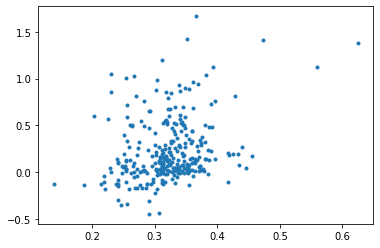

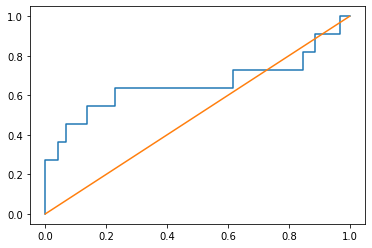

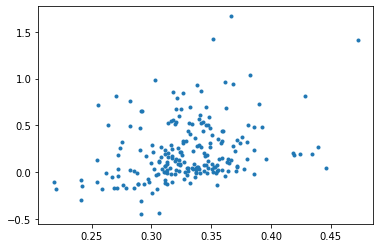

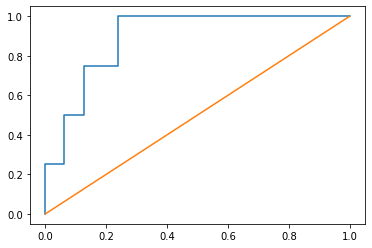

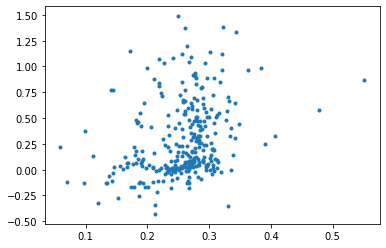

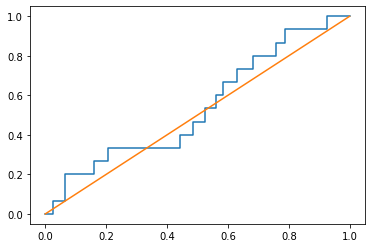

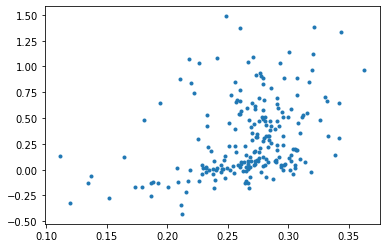

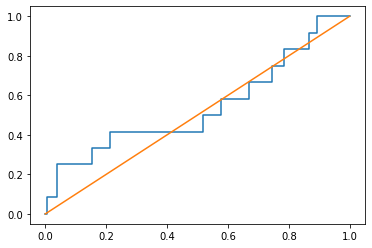

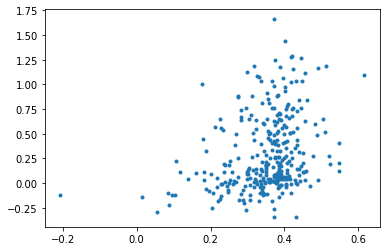

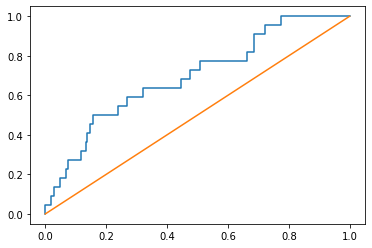

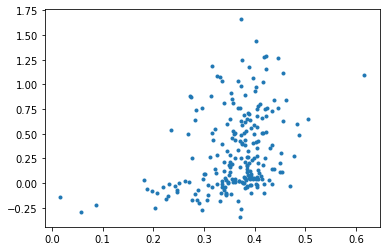

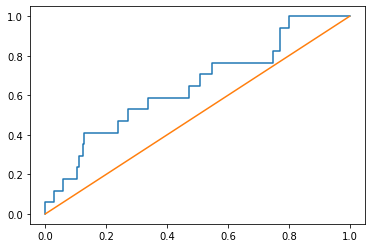

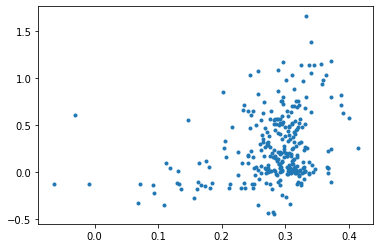

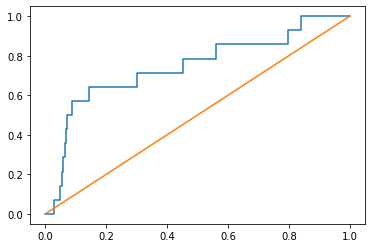

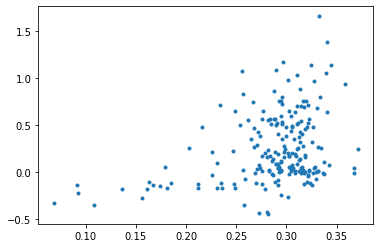

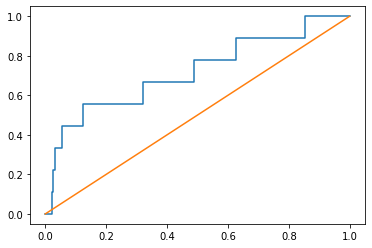

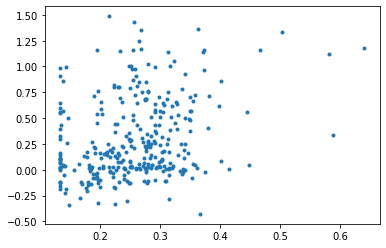

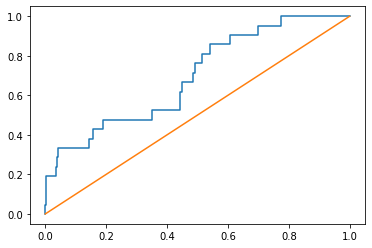

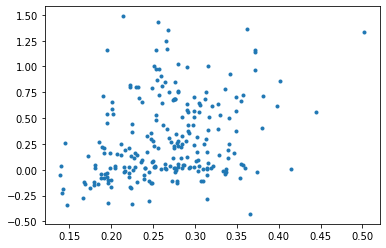

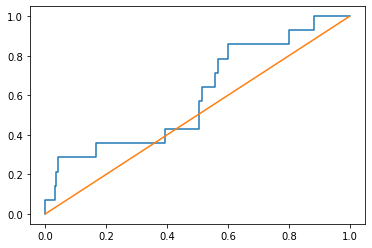

In [75]:
for i in range(5):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs[i], all_aucs[i], all_ns[i], good_corrs[i], good_aucs[i], good_ns[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][4]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)

In [76]:
print(np.mean(all_corrs))
print(np.mean(all_aucs))

print(np.mean(good_corrs))
print(np.mean(good_aucs))

print(all_aucs)
print(good_aucs)

0.2932238778869105
0.6658130049480329
0.33339012562643966
0.6795703941719589
[0.6552496798975672, 0.5399527186761229, 0.6946708463949843, 0.7443064182194616, 0.6948853615520282]
[0.8928571428571428, 0.541871921182266, 0.64593837535014, 0.7171201814058957, 0.6000643500643501]


## Okay now try the model using cosine similarity

In [77]:

cv_models_cos_sim = [all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328) for i in range(5)]


In [85]:
for i in [1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/cos_sim/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cos_sim/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_cos_sim[i].fit([np.array(cv_trains[0]), np.array(cv_trains[2]), np.array(cv_trains[5])], cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21135/21135 [==============================] - 7s 341us/step - loss: 0.4814
Epoch 2/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.2606
Epoch 3/150
21135/21135 [==============================] - 6s 284us/step - loss: 0.0505
Epoch 4/150
21135/21135 [==============================] - 6s 282us/step - loss: 0.0432
Epoch 5/150
21135/21135 [==============================] - 6s 285us/step - loss: 0.0367
Epoch 6/150
21135/21135 [==============================] - 7s 311us/step - loss: 0.0135
Epoch 7/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.0099
Epoch 8/150
21135/21135 [==============================] - 6s 288us/step - loss: 0.0262
Epoch 9/150
21135/21135 [==============================] - 6s 282us/step - loss: 0.0145
Epoch 10/150
21135/21135 [==============================] - 6s 283us/step - loss: 0.0093
Epoch 11/150
21135/21135 [==============================] - 6s 303us/step - loss: 0.0069
Epoch 12/150
21135/21135 [====

21135/21135 [==============================] - 7s 314us/step - loss: 0.0054
Epoch 94/150
21135/21135 [==============================] - 7s 320us/step - loss: 0.0054
Epoch 95/150
21135/21135 [==============================] - 6s 301us/step - loss: 0.0054
Epoch 96/150
21135/21135 [==============================] - 7s 314us/step - loss: 0.0054
Epoch 97/150
21135/21135 [==============================] - 6s 300us/step - loss: 0.0054
Epoch 98/150
21135/21135 [==============================] - 6s 300us/step - loss: 0.0054
Epoch 99/150
21135/21135 [==============================] - 6s 306us/step - loss: 0.0054
Epoch 100/150
21135/21135 [==============================] - 6s 299us/step - loss: 0.0054
Epoch 101/150
21135/21135 [==============================] - 7s 313us/step - loss: 0.0054
Epoch 102/150
21135/21135 [==============================] - 6s 304us/step - loss: 0.0054
Epoch 103/150
21135/21135 [==============================] - 6s 301us/step - loss: 0.0054
Epoch 104/150
21135/21135 [===

20927/20927 [==============================] - 7s 354us/step - loss: 0.0062
Epoch 35/150
20927/20927 [==============================] - 7s 347us/step - loss: 0.0066
Epoch 36/150
20927/20927 [==============================] - 7s 344us/step - loss: 0.0056
Epoch 37/150
20927/20927 [==============================] - 7s 331us/step - loss: 0.0055
Epoch 38/150
20927/20927 [==============================] - 7s 335us/step - loss: 0.0055
Epoch 39/150
20927/20927 [==============================] - 7s 323us/step - loss: 0.0053
Epoch 40/150
20927/20927 [==============================] - 6s 307us/step - loss: 0.0066
Epoch 41/150
20927/20927 [==============================] - 7s 324us/step - loss: 0.0055
Epoch 42/150
20927/20927 [==============================] - 6s 310us/step - loss: 0.0054
Epoch 43/150
20927/20927 [==============================] - 7s 312us/step - loss: 0.0053
Epoch 44/150
20927/20927 [==============================] - 7s 314us/step - loss: 0.0052
Epoch 45/150
20927/20927 [========

20927/20927 [==============================] - 7s 346us/step - loss: 0.0029
Epoch 126/150
20927/20927 [==============================] - 7s 350us/step - loss: 0.0029
Epoch 127/150
20927/20927 [==============================] - 7s 340us/step - loss: 0.0029
Epoch 128/150
20927/20927 [==============================] - 7s 322us/step - loss: 0.0030
Epoch 129/150
20927/20927 [==============================] - 7s 311us/step - loss: 0.0030
Epoch 130/150
20927/20927 [==============================] - 7s 325us/step - loss: 0.0029
Epoch 131/150
20927/20927 [==============================] - 7s 355us/step - loss: 0.0029
Epoch 132/150
20927/20927 [==============================] - 7s 354us/step - loss: 0.0029
Epoch 133/150
20927/20927 [==============================] - 8s 373us/step - loss: 0.0030
Epoch 134/150
20927/20927 [==============================] - 7s 358us/step - loss: 0.0029
Epoch 135/150
20927/20927 [==============================] - 7s 330us/step - loss: 0.0029
Epoch 136/150
20927/2092

21905/21905 [==============================] - 8s 360us/step - loss: 0.0052
Epoch 68/150
21905/21905 [==============================] - 8s 345us/step - loss: 0.0052
Epoch 69/150
21905/21905 [==============================] - 8s 347us/step - loss: 0.0052
Epoch 70/150
21905/21905 [==============================] - 8s 351us/step - loss: 0.0052
Epoch 71/150
21905/21905 [==============================] - 8s 353us/step - loss: 0.0052
Epoch 72/150
21905/21905 [==============================] - 7s 330us/step - loss: 0.0052
Epoch 73/150
21905/21905 [==============================] - 7s 323us/step - loss: 0.0052
Epoch 74/150
21905/21905 [==============================] - 7s 320us/step - loss: 0.0052
Epoch 75/150
21905/21905 [==============================] - 7s 320us/step - loss: 0.0052
Epoch 76/150
21905/21905 [==============================] - 7s 334us/step - loss: 0.0052
Epoch 77/150
21905/21905 [==============================] - 7s 332us/step - loss: 0.0052
Epoch 78/150
21905/21905 [========

20626/20626 [==============================] - 6s 304us/step - loss: 0.0187
Epoch 9/150
20626/20626 [==============================] - 6s 302us/step - loss: 0.0111
Epoch 10/150
20626/20626 [==============================] - 6s 310us/step - loss: 0.0125
Epoch 11/150
20626/20626 [==============================] - 7s 323us/step - loss: 0.0086
Epoch 12/150
20626/20626 [==============================] - 6s 303us/step - loss: 0.0074
Epoch 13/150
20626/20626 [==============================] - 6s 301us/step - loss: 0.0097
Epoch 14/150
20626/20626 [==============================] - 6s 305us/step - loss: 0.0081
Epoch 15/150
20626/20626 [==============================] - 6s 302us/step - loss: 0.0067
Epoch 16/150
20626/20626 [==============================] - 6s 313us/step - loss: 0.0080
Epoch 17/150
20626/20626 [==============================] - 6s 298us/step - loss: 0.0187
Epoch 18/150
20626/20626 [==============================] - 6s 292us/step - loss: 0.0082
Epoch 19/150
20626/20626 [=========

20626/20626 [==============================] - 7s 325us/step - loss: 0.0051
Epoch 101/150
20626/20626 [==============================] - 7s 343us/step - loss: 0.0051
Epoch 102/150
20626/20626 [==============================] - 7s 319us/step - loss: 0.0051
Epoch 103/150
20626/20626 [==============================] - 7s 317us/step - loss: 0.0052
Epoch 104/150
20626/20626 [==============================] - 7s 317us/step - loss: 0.0051
Epoch 105/150
20626/20626 [==============================] - 7s 319us/step - loss: 0.0051
Epoch 106/150
20626/20626 [==============================] - 7s 341us/step - loss: 0.0052
Epoch 107/150
20626/20626 [==============================] - 7s 327us/step - loss: 0.0051
Epoch 108/150
20626/20626 [==============================] - 7s 329us/step - loss: 0.0051
Epoch 109/150
20626/20626 [==============================] - 7s 328us/step - loss: 0.0051
Epoch 110/150
20626/20626 [==============================] - 7s 347us/step - loss: 0.0051
Epoch 111/150
20626/2062

In [80]:
optimal_epochs_cos_sim = [_ for i in range(5)]

In [86]:
for i in range(1,5):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    weights_path = 'Model_checkpoints/cos_sim/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict([np.array(all_cv_vals[i][0]),
                                                               np.array(all_cv_vals[i][2]),
                                                               np.array(all_cv_vals[i][5])]),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_cos_sim[i] = optimal_epoch
    

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.25193387738882755
130
0.3664827668398506
150
0.3045277407854295
40
0.27571979570348887
45


In [87]:
all_aucs_cos_sim = [_ for i in range(5)]
all_corrs_cos_sim = [_ for i in range(5)]
all_ns_cos_sim = [_ for i in range(5)]
good_aucs_cos_sim = [_ for i in range(5)]
good_corrs_cos_sim = [_ for i in range(5)]
good_ns_cos_sim = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.23345054841902793
AUC:  0.7007042253521126
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3527620949259444
AUC:  0.6916666666666667
n:  214




/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Using all perturbagens from test set:
Pearson rho:  nan
AUC:  0.5
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  nan
AUC:  0.5
n:  215


Using all perturbagens from test set:
Pearson rho:  0.24015356549608669
AUC:  0.6680250783699059
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.23971276866548208
AUC:  0.6196078431372549
n:  227


Using all perturbagens from test set:
Pearson rho:  0.15789848310629034
AUC:  0.49353002070393376
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2873054493251977
AUC:  0.6099773242630385
n:  205


Using all perturbagens from test set:
Pearson rho:  0.20043138257567542
AUC:  0.5040885040885041
n:  318
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.18332467122887056
AUC:  0.44787644787644787
n:  236




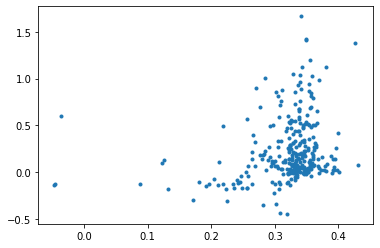

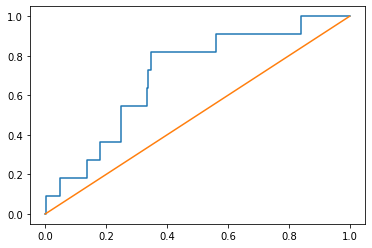

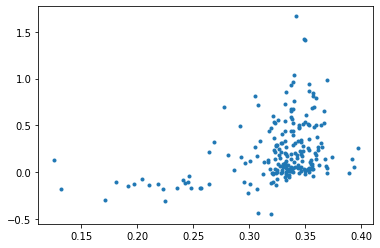

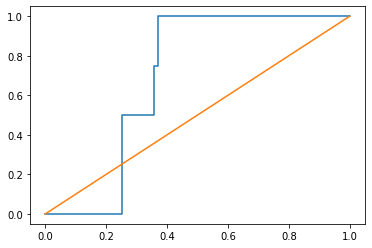

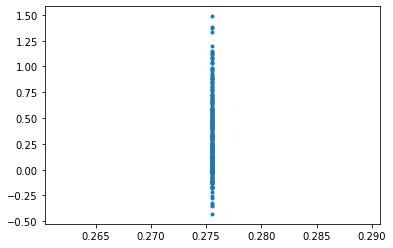

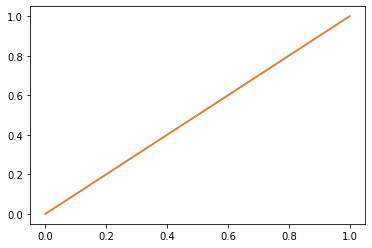

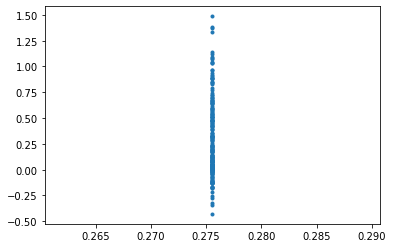

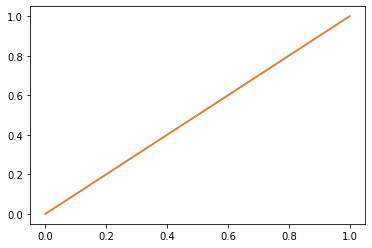

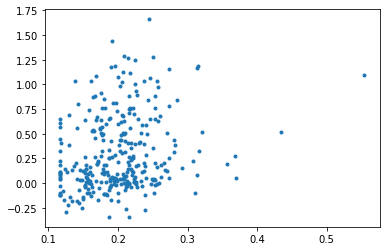

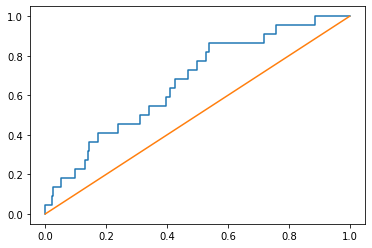

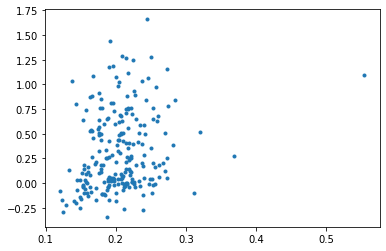

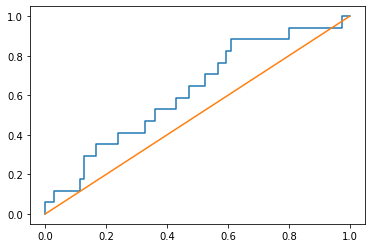

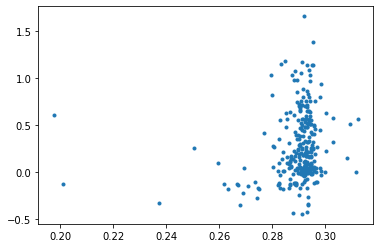

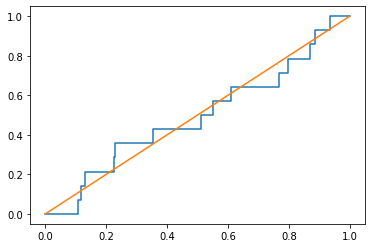

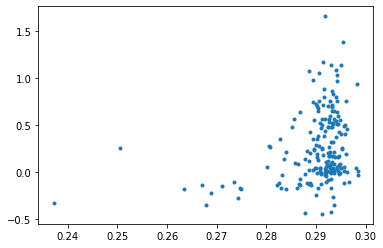

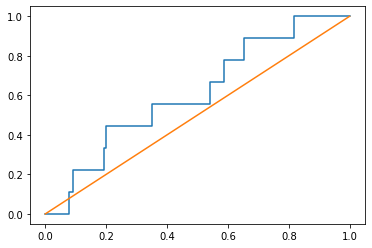

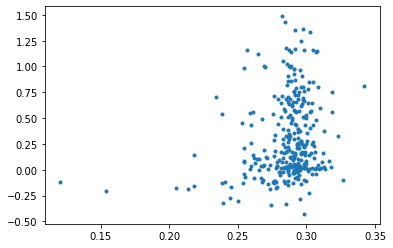

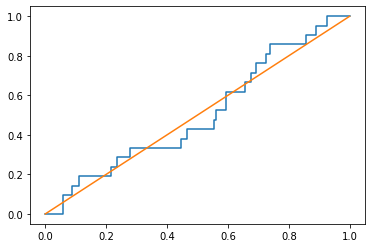

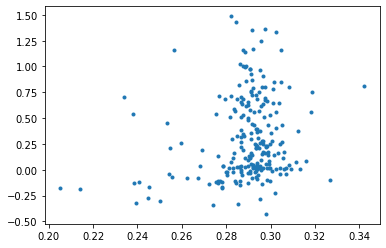

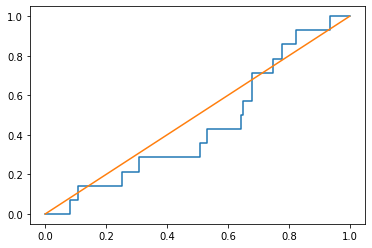

In [88]:
for i in range(5):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs_cos_sim[i]
    weights_fname = 'Model_checkpoints/cos_sim/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_cos_sim[i], all_aucs_cos_sim[i], all_ns_cos_sim[i], good_corrs_cos_sim[i], good_aucs_cos_sim[i], good_ns_cos_sim[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][2]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [89]:
print(np.mean(all_corrs_cos_sim))
print(np.mean(all_aucs_cos_sim))

print(np.mean(good_corrs_cos_sim))
print(np.mean(good_aucs_cos_sim))

print(all_aucs_cos_sim)
print(good_aucs_cos_sim)

nan
0.5732695657028912
nan
0.5738256563886817
[0.7007042253521126, 0.5, 0.6680250783699059, 0.49353002070393376, 0.5040885040885041]
[0.6916666666666667, 0.5, 0.6196078431372549, 0.6099773242630385, 0.44787644787644787]


# Okay now try using absolute value cosine similarity

In [90]:
cv_models_cos_sim_abs = [all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328) for i in range(5)]


In [91]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/cos_sim_abs/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/cos_sim_abs/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_cos_sim_abs[i].fit([np.array(cv_trains[0]), np.array(cv_trains[3]), np.array(cv_trains[5])], cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 9s 438us/step - loss: 1.1114
Epoch 2/150
21364/21364 [==============================] - 6s 303us/step - loss: 0.8570
Epoch 3/150
21364/21364 [==============================] - 7s 314us/step - loss: 0.4089
Epoch 4/150
21364/21364 [==============================] - 7s 308us/step - loss: 0.1348
Epoch 5/150
21364/21364 [==============================] - 7s 308us/step - loss: 0.0738
Epoch 6/150
21364/21364 [==============================] - 7s 338us/step - loss: 0.0439
Epoch 7/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.1171
Epoch 8/150
21364/21364 [==============================] - 7s 322us/step - loss: 0.0921
Epoch 9/150
21364/21364 [==============================] - 7s 316us/step - loss: 0.0788
Epoch 10/150
21364/21364 [==============================] - 7s 332us/step - loss: 0.0698
Epoch 11/150
21364/21364 [==============================] - 7s 337us/step - loss: 0.0224
Epoch 12/150
21364/21364 [====

21364/21364 [==============================] - 7s 325us/step - loss: 0.0038
Epoch 94/150
21364/21364 [==============================] - 7s 310us/step - loss: 0.0037
Epoch 95/150
21364/21364 [==============================] - 7s 308us/step - loss: 0.0037
Epoch 96/150
21364/21364 [==============================] - 7s 325us/step - loss: 0.0036
Epoch 97/150
21364/21364 [==============================] - 7s 350us/step - loss: 0.0035
Epoch 98/150
21364/21364 [==============================] - 8s 362us/step - loss: 0.0036
Epoch 99/150
21364/21364 [==============================] - 8s 370us/step - loss: 0.0035
Epoch 100/150
21364/21364 [==============================] - 8s 374us/step - loss: 0.0034
Epoch 101/150
21364/21364 [==============================] - 8s 356us/step - loss: 0.0035
Epoch 102/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.0034
Epoch 103/150
21364/21364 [==============================] - 7s 320us/step - loss: 0.0033
Epoch 104/150
21364/21364 [===

21135/21135 [==============================] - 7s 309us/step - loss: 0.0065
Epoch 35/150
21135/21135 [==============================] - 6s 296us/step - loss: 0.0063
Epoch 36/150
21135/21135 [==============================] - 7s 331us/step - loss: 0.0075
Epoch 37/150
21135/21135 [==============================] - 7s 338us/step - loss: 0.0067
Epoch 38/150
21135/21135 [==============================] - 8s 356us/step - loss: 0.0074
Epoch 39/150
21135/21135 [==============================] - 7s 343us/step - loss: 0.0070
Epoch 40/150
21135/21135 [==============================] - 7s 334us/step - loss: 0.0082
Epoch 41/150
21135/21135 [==============================] - 7s 340us/step - loss: 0.0068
Epoch 42/150
21135/21135 [==============================] - 7s 316us/step - loss: 0.0078
Epoch 43/150
21135/21135 [==============================] - 7s 322us/step - loss: 0.0106
Epoch 44/150
21135/21135 [==============================] - 6s 306us/step - loss: 0.0070
Epoch 45/150
21135/21135 [========

21135/21135 [==============================] - 9s 407us/step - loss: 0.0030
Epoch 126/150
21135/21135 [==============================] - 9s 447us/step - loss: 0.0030
Epoch 127/150
21135/21135 [==============================] - 8s 370us/step - loss: 0.0030
Epoch 128/150
21135/21135 [==============================] - 7s 334us/step - loss: 0.0031
Epoch 129/150
21135/21135 [==============================] - 7s 337us/step - loss: 0.0030
Epoch 130/150
21135/21135 [==============================] - 8s 356us/step - loss: 0.0030
Epoch 131/150
21135/21135 [==============================] - 7s 329us/step - loss: 0.0029
Epoch 132/150
21135/21135 [==============================] - 7s 340us/step - loss: 0.0029
Epoch 133/150
21135/21135 [==============================] - 7s 316us/step - loss: 0.0032
Epoch 134/150
21135/21135 [==============================] - 7s 333us/step - loss: 0.0032
Epoch 135/150
21135/21135 [==============================] - 7s 328us/step - loss: 0.0030
Epoch 136/150
21135/2113

20927/20927 [==============================] - 6s 303us/step - loss: 0.0052
Epoch 68/150
20927/20927 [==============================] - 6s 303us/step - loss: 0.0052
Epoch 69/150
20927/20927 [==============================] - 6s 288us/step - loss: 0.0052
Epoch 70/150
20927/20927 [==============================] - 6s 281us/step - loss: 0.0052
Epoch 71/150
20927/20927 [==============================] - 6s 300us/step - loss: 0.0052
Epoch 72/150
20927/20927 [==============================] - 6s 309us/step - loss: 0.0052
Epoch 73/150
20927/20927 [==============================] - 6s 290us/step - loss: 0.0052
Epoch 74/150
20927/20927 [==============================] - 6s 299us/step - loss: 0.0052
Epoch 75/150
20927/20927 [==============================] - 6s 302us/step - loss: 0.0052
Epoch 76/150
20927/20927 [==============================] - 7s 325us/step - loss: 0.0052
Epoch 77/150
20927/20927 [==============================] - 6s 310us/step - loss: 0.0052
Epoch 78/150
20927/20927 [========

21905/21905 [==============================] - 8s 362us/step - loss: 0.0236
Epoch 9/150
21905/21905 [==============================] - 8s 361us/step - loss: 0.0833
Epoch 10/150
21905/21905 [==============================] - 8s 356us/step - loss: 0.0406
Epoch 11/150
21905/21905 [==============================] - 8s 359us/step - loss: 0.0119
Epoch 12/150
21905/21905 [==============================] - 8s 363us/step - loss: 0.0089
Epoch 13/150
21905/21905 [==============================] - 7s 336us/step - loss: 0.0077
Epoch 14/150
21905/21905 [==============================] - 8s 387us/step - loss: 0.0150
Epoch 15/150
21905/21905 [==============================] - 8s 369us/step - loss: 0.0249
Epoch 16/150
21905/21905 [==============================] - 10s 475us/step - loss: 0.0144
Epoch 17/150
21905/21905 [==============================] - 10s 470us/step - loss: 0.1273
Epoch 18/150
21905/21905 [==============================] - 11s 482us/step - loss: 0.0115
Epoch 19/150
21905/21905 [======

Epoch 100/150
21905/21905 [==============================] - 7s 300us/step - loss: 0.0052
Epoch 101/150
21905/21905 [==============================] - 7s 328us/step - loss: 0.0052
Epoch 102/150
21905/21905 [==============================] - 7s 322us/step - loss: 0.0052
Epoch 103/150
21905/21905 [==============================] - 7s 312us/step - loss: 0.0052
Epoch 104/150
21905/21905 [==============================] - 7s 311us/step - loss: 0.0052
Epoch 105/150
21905/21905 [==============================] - 7s 314us/step - loss: 0.0052
Epoch 106/150
21905/21905 [==============================] - 8s 343us/step - loss: 0.0052
Epoch 107/150
21905/21905 [==============================] - 8s 348us/step - loss: 0.0052
Epoch 108/150
21905/21905 [==============================] - 8s 351us/step - loss: 0.0052
Epoch 109/150
21905/21905 [==============================] - 7s 336us/step - loss: 0.0052
Epoch 110/150
21905/21905 [==============================] - 7s 335us/step - loss: 0.0052
Epoch 111/

20626/20626 [==============================] - 7s 318us/step - loss: 0.0055
Epoch 42/150
20626/20626 [==============================] - 6s 301us/step - loss: 0.0057
Epoch 43/150
20626/20626 [==============================] - 6s 293us/step - loss: 0.0054
Epoch 44/150
20626/20626 [==============================] - 6s 313us/step - loss: 0.0054
Epoch 45/150
20626/20626 [==============================] - 6s 298us/step - loss: 0.0052
Epoch 46/150
20626/20626 [==============================] - 7s 316us/step - loss: 0.0051
Epoch 47/150
20626/20626 [==============================] - 6s 306us/step - loss: 0.0050
Epoch 48/150
20626/20626 [==============================] - 6s 300us/step - loss: 0.0049
Epoch 49/150
20626/20626 [==============================] - 6s 312us/step - loss: 0.0049
Epoch 50/150
20626/20626 [==============================] - 7s 329us/step - loss: 0.0049
Epoch 51/150
20626/20626 [==============================] - 7s 356us/step - loss: 0.0048
Epoch 52/150
20626/20626 [========

20626/20626 [==============================] - 7s 348us/step - loss: 0.0028
Epoch 133/150
20626/20626 [==============================] - 7s 350us/step - loss: 0.0028
Epoch 134/150
20626/20626 [==============================] - 7s 338us/step - loss: 0.0028
Epoch 135/150
20626/20626 [==============================] - 7s 361us/step - loss: 0.0028
Epoch 136/150
20626/20626 [==============================] - 8s 376us/step - loss: 0.0027
Epoch 137/150
20626/20626 [==============================] - 8s 367us/step - loss: 0.0028
Epoch 138/150
20626/20626 [==============================] - 9s 458us/step - loss: 0.0028
Epoch 139/150
20626/20626 [==============================] - 11s 521us/step - loss: 0.0027
Epoch 140/150
20626/20626 [==============================] - 9s 440us/step - loss: 0.0028
Epoch 141/150
20626/20626 [==============================] - 9s 427us/step - loss: 0.0050
Epoch 142/150
20626/20626 [==============================] - 8s 374us/step - loss: 0.0051
Epoch 143/150
20626/206

In [92]:
optimal_epochs_cos_sim_abs = [_ for i in range(5)]

In [93]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    weights_path = 'Model_checkpoints/cos_sim_abs/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict([np.array(all_cv_vals[i][0]),
                                                               np.array(all_cv_vals[i][3]),
                                                               np.array(all_cv_vals[i][5])]),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_cos_sim_abs[i] = optimal_epoch

0.4695936798172356
50
0.3342488683039913
75
0.2771186884041122
60


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.2679119328114296
75
0.4552627541507835
150


In [94]:
all_aucs_cos_sim_abs = [_ for i in range(5)]
all_corrs_cos_sim_abs = [_ for i in range(5)]
all_ns_cos_sim_abs = [_ for i in range(5)]
good_aucs_cos_sim_abs = [_ for i in range(5)]
good_corrs_cos_sim_abs = [_ for i in range(5)]
good_ns_cos_sim_abs = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.21334436083767527
AUC:  0.5384122919334187
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.31469156261149295
AUC:  0.6178571428571429
n:  214


Using all perturbagens from test set:
Pearson rho:  0.21893496650065244
AUC:  0.49550827423167854
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.28805302715143716
AUC:  0.5036945812807881
n:  215


Using all perturbagens from test set:
Pearson rho:  0.2202432723420604
AUC:  0.6471786833855799
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.29721998310898823
AUC:  0.65406162464986
n:  227




/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Using all perturbagens from test set:
Pearson rho:  nan
AUC:  0.5
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  nan
AUC:  0.5
n:  205


Using all perturbagens from test set:
Pearson rho:  0.26608943135705526
AUC:  0.6620169953503288
n:  318
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2530848588825701
AUC:  0.593951093951094
n:  236




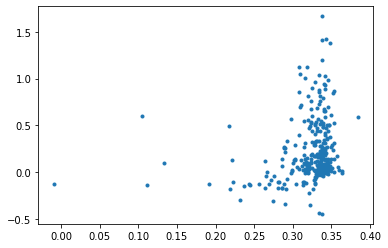

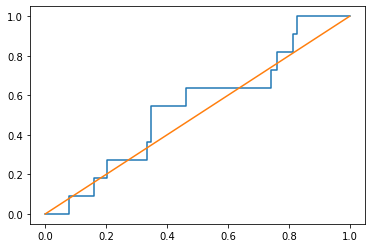

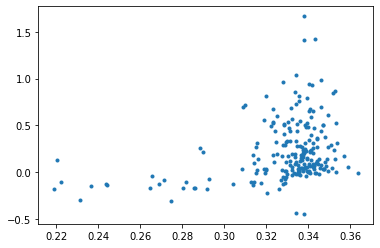

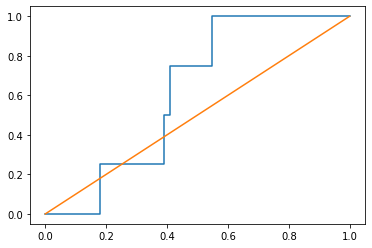

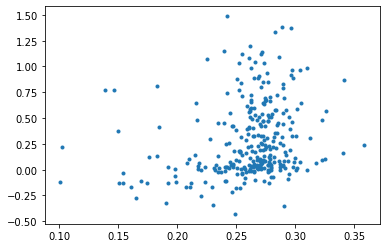

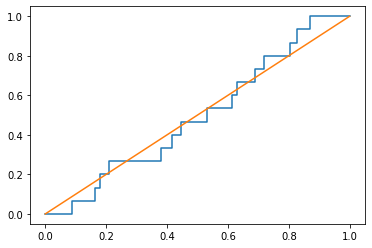

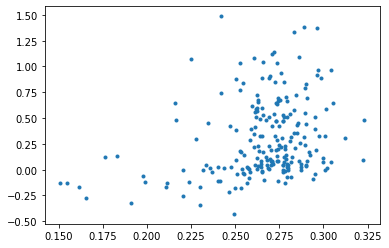

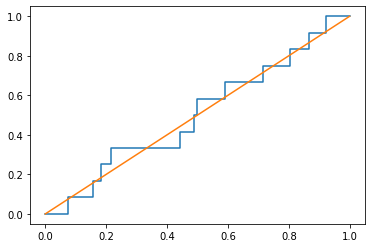

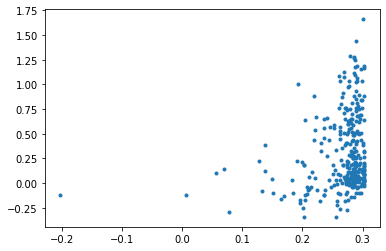

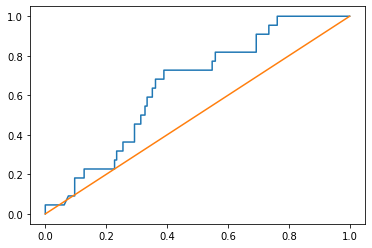

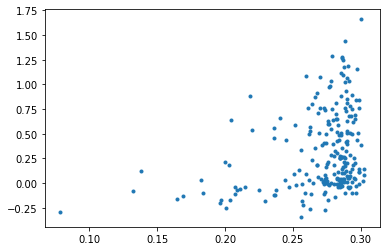

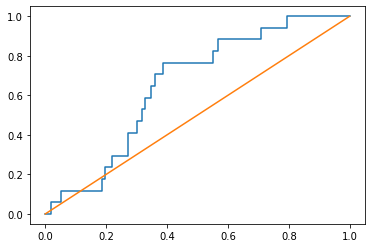

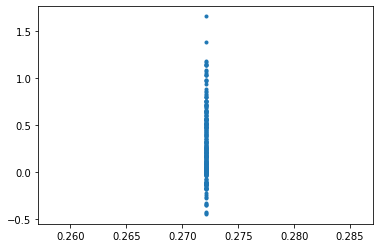

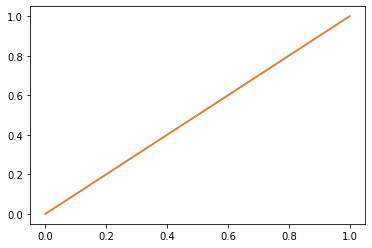

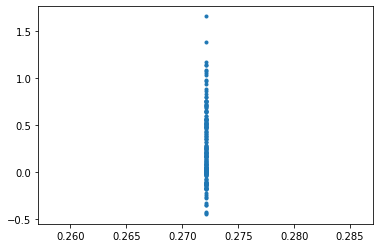

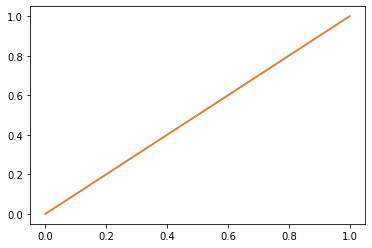

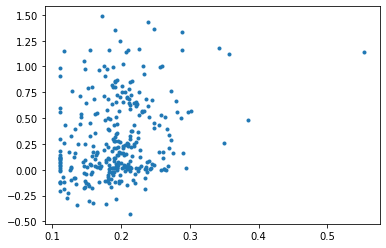

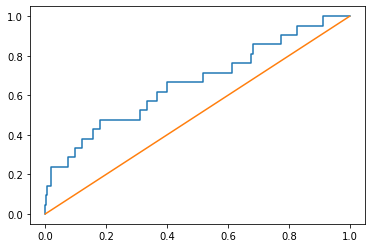

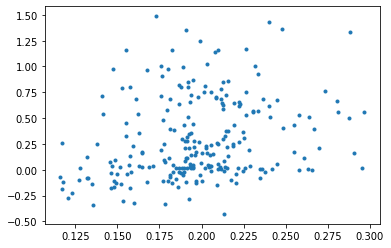

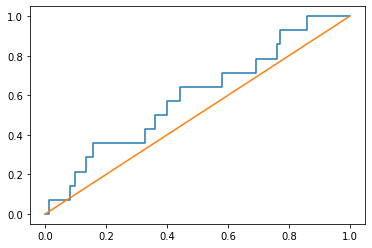

In [95]:
for i in range(5):
    optimal_model = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs_cos_sim_abs[i]
    weights_fname = 'Model_checkpoints/cos_sim_abs/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_cos_sim_abs[i], all_aucs_cos_sim_abs[i], all_ns_cos_sim_abs[i], good_corrs_cos_sim_abs[i], good_aucs_cos_sim_abs[i], good_ns_cos_sim_abs[i] = get_performance(optimal_model.predict([np.array(all_cv_tests[i][0]),
                                   np.array(all_cv_tests[i][3]),
                                   np.array(all_cv_tests[i][5])]),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [97]:
print(np.mean(all_corrs_cos_sim_abs))
print(np.mean(all_aucs_cos_sim_abs))

print(np.mean(good_corrs_cos_sim_abs))
print(np.mean(good_aucs_cos_sim_abs))

print(all_aucs_cos_sim_abs)
print(good_aucs_cos_sim_abs)

nan
0.5686232489802012
nan
0.573912888547777
[0.5384122919334187, 0.49550827423167854, 0.6471786833855799, 0.5, 0.6620169953503288]
[0.6178571428571429, 0.5036945812807881, 0.65406162464986, 0.5, 0.593951093951094]


In [ ]:
# Other things to do:
# Expression only
# Expression plus cell line
# Normalized expression
# Interactome expression only
# The winner of all without dose, plus dose

# Expression only

In [98]:
cv_models_exp_only = [dense_regression_model() for i in range(5)]


In [100]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/expr_only/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/expr_only/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_exp_only[i].fit(np.array(cv_trains[0]), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 9s 413us/step - loss: 0.0343
Epoch 2/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.0081
Epoch 3/150
21364/21364 [==============================] - 7s 325us/step - loss: 0.0072
Epoch 4/150
21364/21364 [==============================] - 7s 310us/step - loss: 0.0059
Epoch 5/150
21364/21364 [==============================] - 7s 318us/step - loss: 0.0056
Epoch 6/150
21364/21364 [==============================] - 7s 342us/step - loss: 0.0050
Epoch 7/150
21364/21364 [==============================] - 7s 313us/step - loss: 0.0047
Epoch 8/150
21364/21364 [==============================] - 7s 316us/step - loss: 0.0045
Epoch 9/150
21364/21364 [==============================] - 7s 331us/step - loss: 0.0044
Epoch 10/150
21364/21364 [==============================] - 7s 345us/step - loss: 0.0042
Epoch 11/150
21364/21364 [==============================] - 13s 629us/step - loss: 0.00430s - loss: 0.0
Epoch 12/150
21

21364/21364 [==============================] - 11s 508us/step - loss: 7.5196e-04
Epoch 92/150
21364/21364 [==============================] - 11s 504us/step - loss: 7.1273e-04
Epoch 93/150
21364/21364 [==============================] - 13s 591us/step - loss: 7.0331e-04
Epoch 94/150
21364/21364 [==============================] - 10s 484us/step - loss: 6.9030e-04
Epoch 95/150
21364/21364 [==============================] - 9s 408us/step - loss: 6.8907e-04
Epoch 96/150
21364/21364 [==============================] - 9s 411us/step - loss: 7.0738e-04
Epoch 97/150
21364/21364 [==============================] - 8s 371us/step - loss: 7.0227e-04
Epoch 98/150
21364/21364 [==============================] - 8s 385us/step - loss: 7.0449e-04
Epoch 99/150
21364/21364 [==============================] - 8s 368us/step - loss: 6.5830e-04
Epoch 100/150
21364/21364 [==============================] - 8s 361us/step - loss: 6.9439e-04
Epoch 101/150
21364/21364 [==============================] - 8s 385us/step - l

21135/21135 [==============================] - 7s 351us/step - loss: 0.0030
Epoch 30/150
21135/21135 [==============================] - 7s 328us/step - loss: 0.0029
Epoch 31/150
21135/21135 [==============================] - 7s 344us/step - loss: 0.0028
Epoch 32/150
21135/21135 [==============================] - 7s 330us/step - loss: 0.0029
Epoch 33/150
21135/21135 [==============================] - 7s 325us/step - loss: 0.0028
Epoch 34/150
21135/21135 [==============================] - 7s 345us/step - loss: 0.0027
Epoch 35/150
21135/21135 [==============================] - 8s 366us/step - loss: 0.0027
Epoch 36/150
21135/21135 [==============================] - 8s 396us/step - loss: 0.0027
Epoch 37/150
21135/21135 [==============================] - 7s 342us/step - loss: 0.0025
Epoch 38/150
21135/21135 [==============================] - 7s 347us/step - loss: 0.0025
Epoch 39/150
21135/21135 [==============================] - 7s 348us/step - loss: 0.0023
Epoch 40/150
21135/21135 [========

21135/21135 [==============================] - 9s 429us/step - loss: 8.2388e-04
Epoch 120/150
21135/21135 [==============================] - 9s 421us/step - loss: 6.4261e-04
Epoch 121/150
21135/21135 [==============================] - 8s 370us/step - loss: 5.9918e-04
Epoch 122/150
21135/21135 [==============================] - 7s 348us/step - loss: 6.0356e-04
Epoch 123/150
21135/21135 [==============================] - 8s 381us/step - loss: 6.5446e-04
Epoch 124/150
21135/21135 [==============================] - 8s 391us/step - loss: 6.0752e-04
Epoch 125/150
21135/21135 [==============================] - 11s 508us/step - loss: 5.7515e-04
Epoch 126/150
21135/21135 [==============================] - 10s 462us/step - loss: 7.0036e-04
Epoch 127/150
21135/21135 [==============================] - 10s 493us/step - loss: 6.7585e-04
Epoch 128/150
21135/21135 [==============================] - 10s 452us/step - loss: 5.9804e-04
Epoch 129/150
21135/21135 [==============================] - 9s 430us/

20927/20927 [==============================] - 6s 290us/step - loss: 0.0014
Epoch 60/150
20927/20927 [==============================] - 6s 288us/step - loss: 0.0015
Epoch 61/150
20927/20927 [==============================] - 7s 328us/step - loss: 0.0014
Epoch 62/150
20927/20927 [==============================] - 6s 278us/step - loss: 0.0013
Epoch 63/150
20927/20927 [==============================] - 6s 282us/step - loss: 0.0013
Epoch 64/150
20927/20927 [==============================] - 6s 289us/step - loss: 0.0013
Epoch 65/150
20927/20927 [==============================] - 6s 279us/step - loss: 0.0013
Epoch 66/150
20927/20927 [==============================] - 7s 347us/step - loss: 0.0013
Epoch 67/150
20927/20927 [==============================] - 7s 311us/step - loss: 0.0013
Epoch 68/150
20927/20927 [==============================] - 6s 299us/step - loss: 0.0012
Epoch 69/150
20927/20927 [==============================] - 6s 292us/step - loss: 0.0012
Epoch 70/150
20927/20927 [========

20927/20927 [==============================] - 8s 372us/step - loss: 5.1315e-04
Epoch 148/150
20927/20927 [==============================] - 10s 482us/step - loss: 5.1807e-04
Epoch 149/150
20927/20927 [==============================] - 9s 406us/step - loss: 5.3001e-04
Epoch 150/150
20927/20927 [==============================] - 8s 384us/step - loss: 5.2384e-04
Epoch 1/150
21905/21905 [==============================] - 10s 441us/step - loss: 0.0139
Epoch 2/150
21905/21905 [==============================] - 8s 375us/step - loss: 0.0055
Epoch 3/150
21905/21905 [==============================] - 7s 324us/step - loss: 0.0051
Epoch 4/150
21905/21905 [==============================] - 7s 324us/step - loss: 0.0050
Epoch 5/150
21905/21905 [==============================] - 7s 324us/step - loss: 0.0049
Epoch 6/150
21905/21905 [==============================] - 8s 367us/step - loss: 0.0048
Epoch 7/150
21905/21905 [==============================] - 8s 368us/step - loss: 0.0046
Epoch 8/150
21905/21

21905/21905 [==============================] - 11s 499us/step - loss: 7.6498e-04
Epoch 88/150
21905/21905 [==============================] - 10s 459us/step - loss: 7.5864e-04
Epoch 89/150
21905/21905 [==============================] - 9s 428us/step - loss: 6.5635e-04
Epoch 90/150
21905/21905 [==============================] - 9s 413us/step - loss: 6.8053e-04
Epoch 91/150
21905/21905 [==============================] - 10s 462us/step - loss: 6.5006e-04
Epoch 92/150
21905/21905 [==============================] - 9s 428us/step - loss: 6.8999e-04
Epoch 93/150
21905/21905 [==============================] - 10s 460us/step - loss: 7.8515e-04
Epoch 94/150
21905/21905 [==============================] - 10s 444us/step - loss: 6.4002e-04
Epoch 95/150
21905/21905 [==============================] - 12s 555us/step - loss: 6.6178e-04
Epoch 96/150
21905/21905 [==============================] - 12s 542us/step - loss: 6.4895e-04
Epoch 97/150
21905/21905 [==============================] - 10s 468us/step -

Epoch 25/150
20626/20626 [==============================] - 11s 528us/step - loss: 0.0027
Epoch 26/150
20626/20626 [==============================] - 13s 626us/step - loss: 0.0027
Epoch 27/150
20626/20626 [==============================] - 11s 553us/step - loss: 0.0027
Epoch 28/150
20626/20626 [==============================] - 10s 507us/step - loss: 0.0025
Epoch 29/150
20626/20626 [==============================] - 10s 477us/step - loss: 0.0025
Epoch 30/150
20626/20626 [==============================] - 9s 441us/step - loss: 0.0024
Epoch 31/150
20626/20626 [==============================] - 10s 478us/step - loss: 0.0023
Epoch 32/150
20626/20626 [==============================] - 10s 466us/step - loss: 0.0022
Epoch 33/150
20626/20626 [==============================] - 11s 517us/step - loss: 0.0021
Epoch 34/150
20626/20626 [==============================] - 10s 503us/step - loss: 0.0021
Epoch 35/150
20626/20626 [==============================] - 11s 545us/step - loss: 0.0022
Epoch 36/15

20626/20626 [==============================] - 11s 512us/step - loss: 6.0672e-04
Epoch 115/150
20626/20626 [==============================] - 11s 521us/step - loss: 6.1975e-04
Epoch 116/150
20626/20626 [==============================] - 11s 525us/step - loss: 5.6512e-04
Epoch 117/150
20626/20626 [==============================] - 10s 499us/step - loss: 5.7748e-04
Epoch 118/150
20626/20626 [==============================] - 11s 517us/step - loss: 5.7716e-04
Epoch 119/150
20626/20626 [==============================] - 10s 487us/step - loss: 5.7925e-04
Epoch 120/150
20626/20626 [==============================] - 10s 488us/step - loss: 5.5424e-04
Epoch 121/150
20626/20626 [==============================] - 11s 531us/step - loss: 5.6374e-04
Epoch 122/150
20626/20626 [==============================] - 11s 514us/step - loss: 5.8443e-04
Epoch 123/150
20626/20626 [==============================] - 10s 509us/step - loss: 5.6305e-04
Epoch 124/150
20626/20626 [==============================] - 11s

In [101]:
optimal_epochs_exp_only = [_ for i in range(5)]

In [104]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model()
    weights_path = 'Model_checkpoints/expr_only/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(all_cv_vals[i][0])),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_exp_only[i] = optimal_epoch

0.4567092792107053
35
0.4329066975002038
65
0.29763179587955313
35
0.45038074324024713
65
0.4922196625945371
145


In [105]:
all_aucs_exp_only = [_ for i in range(5)]
all_corrs_exp_only = [_ for i in range(5)]
all_ns_exp_only = [_ for i in range(5)]
good_aucs_exp_only = [_ for i in range(5)]
good_corrs_exp_only = [_ for i in range(5)]
good_ns_exp_only = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.2518109644272186
AUC:  0.706786171574904
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.34461904800861376
AUC:  0.8130952380952381
n:  214


Using all perturbagens from test set:
Pearson rho:  0.27946660805206075
AUC:  0.6040189125295508
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3682824507281417
AUC:  0.6666666666666666
n:  215


Using all perturbagens from test set:
Pearson rho:  0.27177080127595277
AUC:  0.663949843260188
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.25897152707081866
AUC:  0.5787114845938375
n:  227


Using all perturbagens from test set:
Pearson rho:  0.3552906394105515
AUC:  0.7070393374741201
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.31321323831559816
AUC:  0.5651927437641724
n:  205


Using all perturbagens from test set:
Pearson rho:  0.3539142146407554
AUC:  

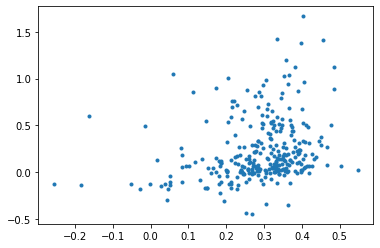

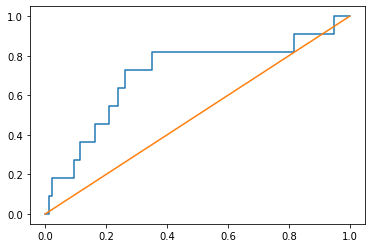

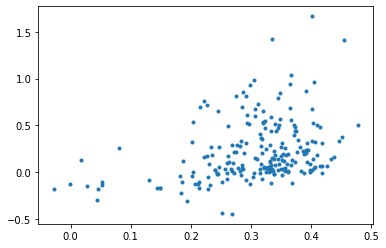

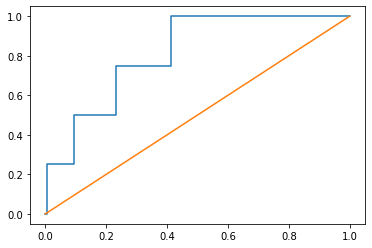

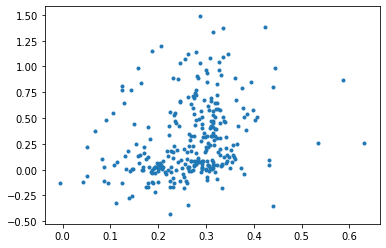

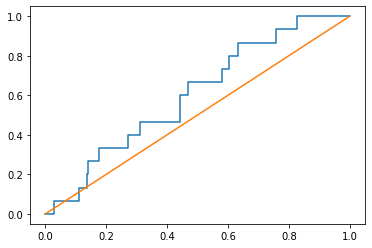

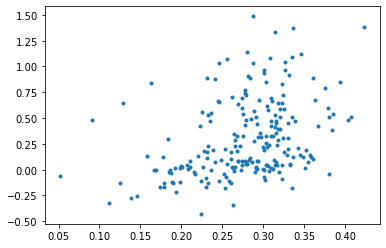

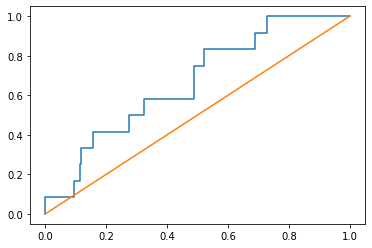

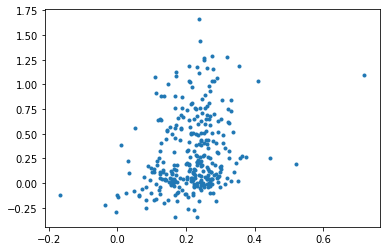

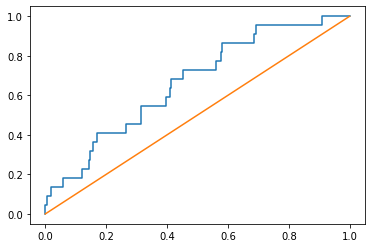

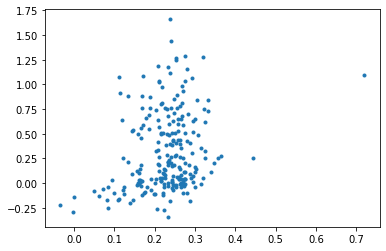

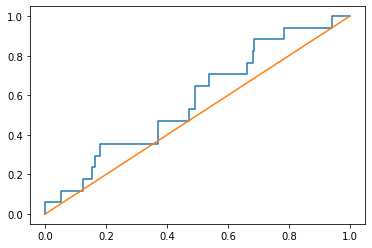

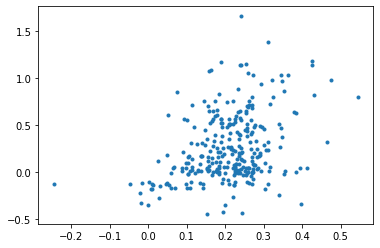

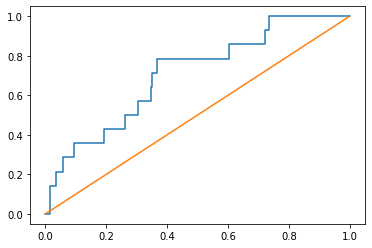

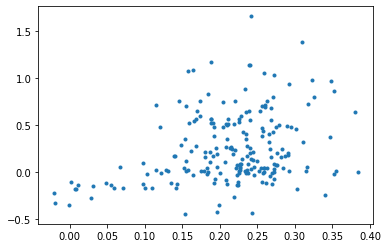

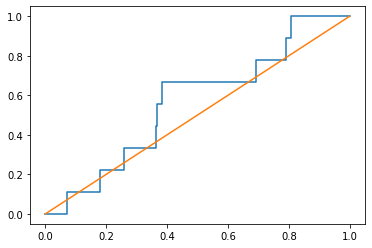

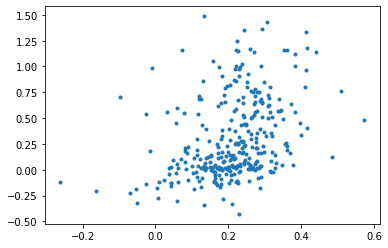

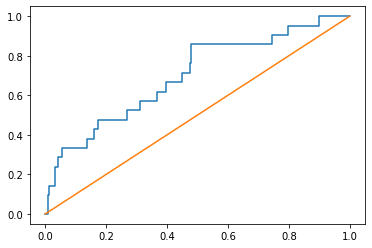

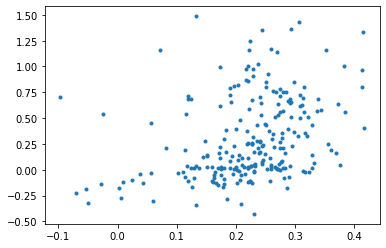

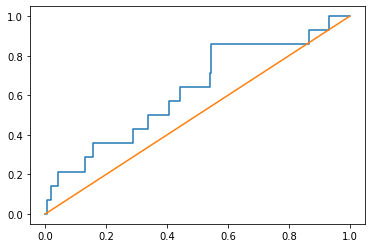

In [107]:
for i in range(5):
    optimal_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_exp_only[i], all_aucs_exp_only[i], all_ns_exp_only[i], good_corrs_exp_only[i], good_aucs_exp_only[i], good_ns_exp_only[i] = get_performance(optimal_model.predict(np.array(all_cv_tests[i][0])),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [109]:
print(np.mean(all_corrs_exp_only))
print(np.mean(all_aucs_exp_only))

print(np.mean(good_corrs_exp_only))
print(np.mean(good_aucs_exp_only))

print(all_aucs_exp_only)
print(good_aucs_exp_only)

0.3024506455613078
0.6761375927464923
0.32466638804245107
0.649701051591808
[0.706786171574904, 0.6040189125295508, 0.663949843260188, 0.7070393374741201, 0.6988936988936988]
[0.8130952380952381, 0.6666666666666666, 0.5787114845938375, 0.5651927437641724, 0.6248391248391248]


# Interactome expression only

In [122]:
cv_models_interactome_only = [dense_regression_model(input_dim = 278) for i in range(5)]


In [123]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/interactome_only/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/interactome_only/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    
    cv_trains = all_cv_trains[i]
    cv_vals = all_cv_vals[i]
    cv_tests = all_cv_tests[i]
    cv_models_interactome_only[i].fit(np.array(cv_trains[1]), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

Epoch 1/150
21364/21364 [==============================] - 4s 210us/step - loss: 0.0064
Epoch 2/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0053
Epoch 3/150
21364/21364 [==============================] - 2s 108us/step - loss: 0.0051
Epoch 4/150
21364/21364 [==============================] - 2s 109us/step - loss: 0.0049
Epoch 5/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0047
Epoch 6/150
21364/21364 [==============================] - 2s 114us/step - loss: 0.0045
Epoch 7/150
21364/21364 [==============================] - 2s 116us/step - loss: 0.0044
Epoch 8/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0041
Epoch 9/150
21364/21364 [==============================] - 2s 109us/step - loss: 0.0040
Epoch 10/150
21364/21364 [==============================] - 2s 112us/step - loss: 0.0038
Epoch 11/150
21364/21364 [==============================] - 2s 116us/step - loss: 0.0036
Epoch 12/150
21364/21364 [====

21364/21364 [==============================] - 3s 135us/step - loss: 0.0012
Epoch 94/150
21364/21364 [==============================] - 3s 128us/step - loss: 0.0012
Epoch 95/150
21364/21364 [==============================] - 3s 123us/step - loss: 0.0012
Epoch 96/150
21364/21364 [==============================] - 3s 122us/step - loss: 0.0012
Epoch 97/150
21364/21364 [==============================] - 3s 124us/step - loss: 0.0012
Epoch 98/150
21364/21364 [==============================] - 3s 120us/step - loss: 0.0012
Epoch 99/150
21364/21364 [==============================] - 3s 120us/step - loss: 0.0012
Epoch 100/150
21364/21364 [==============================] - 2s 116us/step - loss: 0.0012
Epoch 101/150
21364/21364 [==============================] - 3s 119us/step - loss: 0.0012
Epoch 102/150
21364/21364 [==============================] - 3s 124us/step - loss: 0.0012
Epoch 103/150
21364/21364 [==============================] - 3s 120us/step - loss: 0.0012
Epoch 104/150
21364/21364 [===

21135/21135 [==============================] - 3s 119us/step - loss: 0.0020
Epoch 35/150
21135/21135 [==============================] - 3s 119us/step - loss: 0.0019
Epoch 36/150
21135/21135 [==============================] - 2s 116us/step - loss: 0.0018
Epoch 37/150
21135/21135 [==============================] - 3s 121us/step - loss: 0.0018
Epoch 38/150
21135/21135 [==============================] - 2s 115us/step - loss: 0.0018
Epoch 39/150
21135/21135 [==============================] - 2s 113us/step - loss: 0.0019
Epoch 40/150
21135/21135 [==============================] - 2s 112us/step - loss: 0.0018
Epoch 41/150
21135/21135 [==============================] - 3s 120us/step - loss: 0.0018
Epoch 42/150
21135/21135 [==============================] - 2s 113us/step - loss: 0.0018
Epoch 43/150
21135/21135 [==============================] - 2s 109us/step - loss: 0.0017
Epoch 44/150
21135/21135 [==============================] - 2s 110us/step - loss: 0.0017
Epoch 45/150
21135/21135 [========

21135/21135 [==============================] - 3s 135us/step - loss: 0.0011
Epoch 126/150
21135/21135 [==============================] - 3s 136us/step - loss: 0.0011
Epoch 127/150
21135/21135 [==============================] - 3s 138us/step - loss: 0.0011
Epoch 128/150
21135/21135 [==============================] - 3s 141us/step - loss: 0.0011
Epoch 129/150
21135/21135 [==============================] - 3s 137us/step - loss: 0.0011
Epoch 130/150
21135/21135 [==============================] - 3s 135us/step - loss: 0.0010
Epoch 131/150
21135/21135 [==============================] - 3s 136us/step - loss: 0.0010
Epoch 132/150
21135/21135 [==============================] - 3s 136us/step - loss: 0.0010
Epoch 133/150
21135/21135 [==============================] - 3s 131us/step - loss: 0.0010
Epoch 134/150
21135/21135 [==============================] - 3s 147us/step - loss: 0.0010
Epoch 135/150
21135/21135 [==============================] - 3s 135us/step - loss: 0.0010
Epoch 136/150
21135/2113

20927/20927 [==============================] - 3s 156us/step - loss: 0.0014
Epoch 67/150
20927/20927 [==============================] - 3s 157us/step - loss: 0.0014
Epoch 68/150
20927/20927 [==============================] - 3s 154us/step - loss: 0.0014
Epoch 69/150
20927/20927 [==============================] - 3s 147us/step - loss: 0.0013
Epoch 70/150
20927/20927 [==============================] - 3s 143us/step - loss: 0.0013
Epoch 71/150
20927/20927 [==============================] - 3s 145us/step - loss: 0.0013
Epoch 72/150
20927/20927 [==============================] - 3s 139us/step - loss: 0.0013
Epoch 73/150
20927/20927 [==============================] - 3s 133us/step - loss: 0.0013
Epoch 74/150
20927/20927 [==============================] - 3s 133us/step - loss: 0.0012 0s - los
Epoch 75/150
20927/20927 [==============================] - 3s 136us/step - loss: 0.0013
Epoch 76/150
20927/20927 [==============================] - 3s 137us/step - loss: 0.0013
Epoch 77/150
20927/20927 

21905/21905 [==============================] - 3s 142us/step - loss: 0.0041
Epoch 7/150
21905/21905 [==============================] - 3s 139us/step - loss: 0.0039
Epoch 8/150
21905/21905 [==============================] - 3s 140us/step - loss: 0.0036
Epoch 9/150
21905/21905 [==============================] - 3s 141us/step - loss: 0.0035
Epoch 10/150
21905/21905 [==============================] - 3s 140us/step - loss: 0.0033
Epoch 11/150
21905/21905 [==============================] - 3s 141us/step - loss: 0.0033
Epoch 12/150
21905/21905 [==============================] - 3s 140us/step - loss: 0.0031
Epoch 13/150
21905/21905 [==============================] - 3s 138us/step - loss: 0.0030
Epoch 14/150
21905/21905 [==============================] - 3s 137us/step - loss: 0.0029
Epoch 15/150
21905/21905 [==============================] - 3s 133us/step - loss: 0.0028
Epoch 16/150
21905/21905 [==============================] - 3s 130us/step - loss: 0.0027
Epoch 17/150
21905/21905 [===========

21905/21905 [==============================] - 3s 118us/step - loss: 0.0011
Epoch 99/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0012
Epoch 100/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0012
Epoch 101/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0011
Epoch 102/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0012
Epoch 103/150
21905/21905 [==============================] - 3s 115us/step - loss: 0.0011
Epoch 104/150
21905/21905 [==============================] - 3s 116us/step - loss: 0.0011
Epoch 105/150
21905/21905 [==============================] - 3s 117us/step - loss: 0.0011
Epoch 106/150
21905/21905 [==============================] - 3s 120us/step - loss: 0.0011
Epoch 107/150
21905/21905 [==============================] - 3s 118us/step - loss: 0.0011
Epoch 108/150
21905/21905 [==============================] - 2s 114us/step - loss: 0.0011
Epoch 109/150
21905/21905

20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 40/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 41/150
20626/20626 [==============================] - 2s 109us/step - loss: 0.0017
Epoch 42/150
20626/20626 [==============================] - 2s 118us/step - loss: 0.0018
Epoch 43/150
20626/20626 [==============================] - 2s 119us/step - loss: 0.0017
Epoch 44/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0017
Epoch 45/150
20626/20626 [==============================] - 2s 105us/step - loss: 0.0016
Epoch 46/150
20626/20626 [==============================] - 2s 108us/step - loss: 0.0016
Epoch 47/150
20626/20626 [==============================] - 2s 107us/step - loss: 0.0016
Epoch 48/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0016
Epoch 49/150
20626/20626 [==============================] - 2s 106us/step - loss: 0.0016
Epoch 50/150
20626/20626 [========

20626/20626 [==============================] - 2s 105us/step - loss: 9.8177e-04
Epoch 131/150
20626/20626 [==============================] - 2s 107us/step - loss: 9.7711e-04
Epoch 132/150
20626/20626 [==============================] - 2s 106us/step - loss: 9.9261e-04
Epoch 133/150
20626/20626 [==============================] - 2s 105us/step - loss: 0.0010
Epoch 134/150
20626/20626 [==============================] - 2s 108us/step - loss: 9.6428e-04
Epoch 135/150
20626/20626 [==============================] - 2s 105us/step - loss: 9.9689e-04
Epoch 136/150
20626/20626 [==============================] - 2s 107us/step - loss: 9.6104e-04
Epoch 137/150
20626/20626 [==============================] - 2s 106us/step - loss: 9.5499e-04
Epoch 138/150
20626/20626 [==============================] - 2s 106us/step - loss: 9.6074e-04
Epoch 139/150
20626/20626 [==============================] - 2s 105us/step - loss: 9.4991e-04
Epoch 140/150
20626/20626 [==============================] - 2s 105us/step - l

In [124]:
optimal_epochs_interactome_only = [_ for i in range(5)]

In [125]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model(input_dim = 278)
    weights_path = 'Model_checkpoints/interactome_only/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(all_cv_vals[i][1])),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_interactome_only[i] = optimal_epoch

0.4269233557612811
95
0.3250329977722133
75
0.3049482190607339
120
0.2589576388342546
10
0.38446342876926687
30


In [126]:
all_aucs_interactome_only = [_ for i in range(5)]
all_corrs_interactome_only = [_ for i in range(5)]
all_ns_interactome_only = [_ for i in range(5)]
good_aucs_interactome_only = [_ for i in range(5)]
good_corrs_interactome_only = [_ for i in range(5)]
good_ns_interactome_only = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.1959981935052678
AUC:  0.6129961587708067
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.25115649668034545
AUC:  0.6940476190476191
n:  214


Using all perturbagens from test set:
Pearson rho:  0.16639376021332566
AUC:  0.5829787234042554
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.17913680571906002
AUC:  0.45279146141215104
n:  215


Using all perturbagens from test set:
Pearson rho:  0.23753457959042426
AUC:  0.6089341692789969
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.23896960046773083
AUC:  0.5532212885154062
n:  227


Using all perturbagens from test set:
Pearson rho:  0.27657248479176355
AUC:  0.7968426501035197
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.35213275359620777
AUC:  0.75
n:  205


Using all perturbagens from test set:
Pearson rho:  0.30059909330592227
AUC:  0.625781

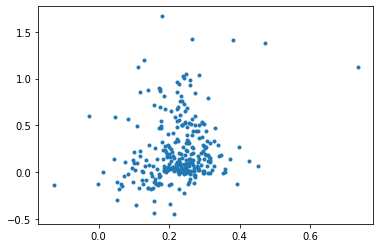

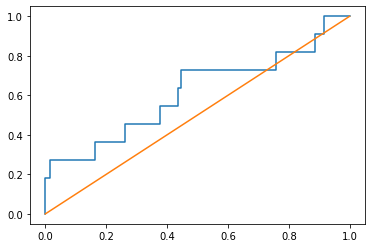

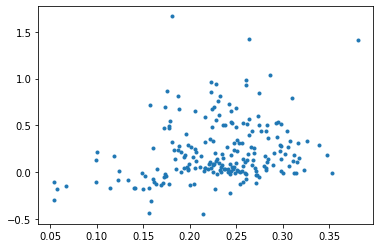

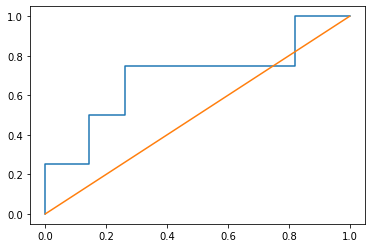

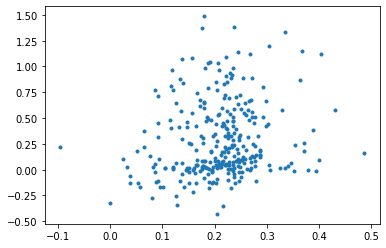

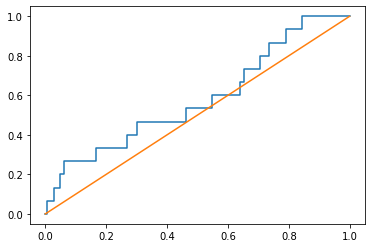

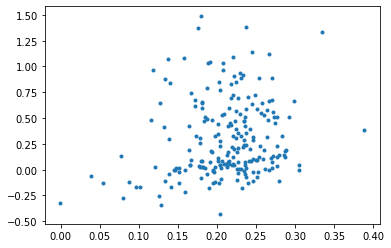

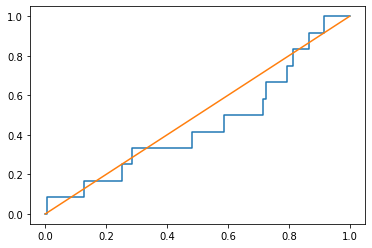

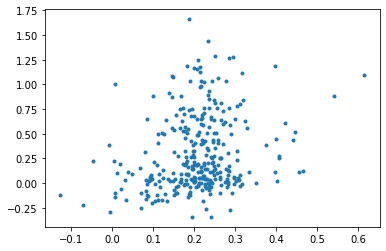

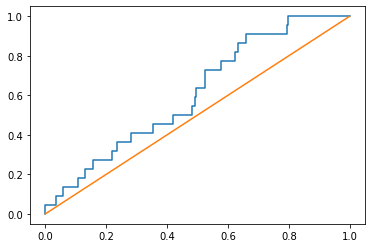

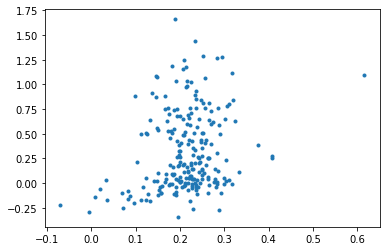

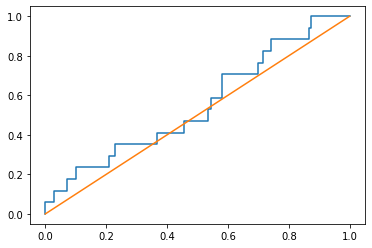

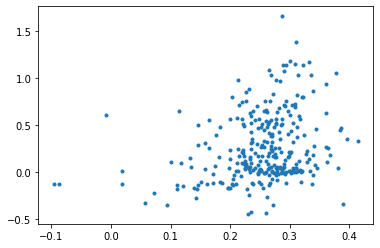

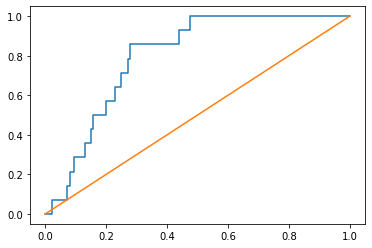

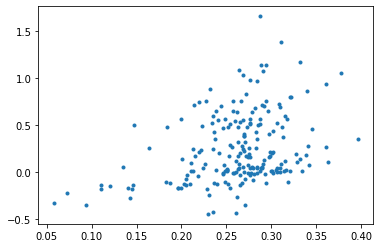

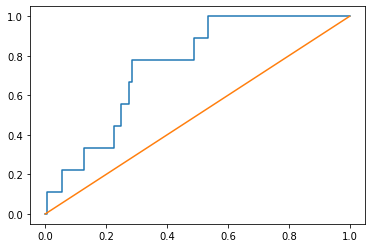

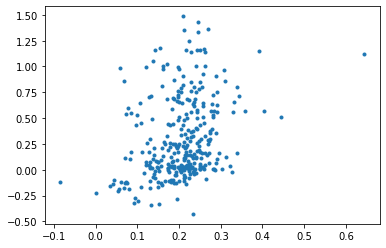

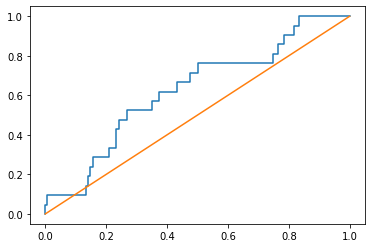

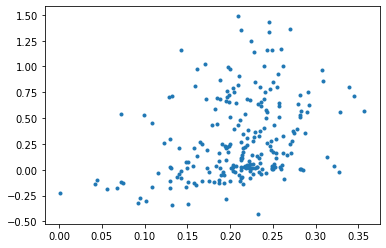

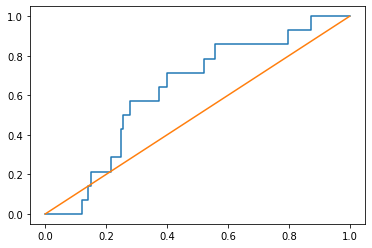

In [127]:
for i in range(5):
    optimal_model = dense_regression_model(input_dim = 278)
    optimal_epoch = optimal_epochs_interactome_only[i]
    weights_fname = 'Model_checkpoints/interactome_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_interactome_only[i], all_aucs_interactome_only[i], all_ns_interactome_only[i], good_corrs_interactome_only[i], good_aucs_interactome_only[i], good_ns_interactome_only[i] = get_performance(optimal_model.predict(np.array(all_cv_tests[i][1])),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [128]:
print(np.mean(all_corrs_interactome_only))
print(np.mean(all_aucs_interactome_only))

print(np.mean(good_corrs_interactome_only))
print(np.mean(good_aucs_interactome_only))

print(all_aucs_interactome_only)
print(good_aucs_interactome_only)

0.23541962228134067
0.6455066654678407
0.2682598418158407
0.6159451497281112
[0.6129961587708067, 0.5829787234042554, 0.6089341692789969, 0.7968426501035197, 0.6257816257816258]
[0.6940476190476191, 0.45279146141215104, 0.5532212885154062, 0.75, 0.6296653796653797]


# Normalized expression

In [129]:
cv_models_normalized_expression = [dense_regression_model() for i in range(5)]


In [131]:
for i in [0,1,2,3,4]:
    try:
        os.makedirs('Model_checkpoints/norm_expression/fold_'+str(i))
    except:
        pass
    checkpoint_path = 'Model_checkpoints/norm_expression/fold_'+str(i)+'/saved-model-{epoch:02d}.hdf5'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=False,
        period = 5
    )
    train_x = get_normalized_2d_list(all_cv_trains[i][0])
    cv_trains = all_cv_trains[i]
    cv_models_normalized_expression[i].fit(np.array(train_x), cv_trains[6],
                     batch_size = 64, epochs = 150,
                     sample_weight = np.array(cv_trains[7]),
                     shuffle = True, callbacks = [model_checkpoint_callback])

5
2005
4005
6005
8005
10005
12005
14005
16005
18005
20005
Epoch 1/150
21364/21364 [==============================] - 12s 544us/step - loss: 0.0121
Epoch 2/150
21364/21364 [==============================] - 7s 313us/step - loss: 0.0058
Epoch 3/150
21364/21364 [==============================] - 7s 314us/step - loss: 0.0054
Epoch 4/150
21364/21364 [==============================] - 7s 326us/step - loss: 0.0052
Epoch 5/150
21364/21364 [==============================] - 7s 304us/step - loss: 0.0051
Epoch 6/150
21364/21364 [==============================] - 7s 318us/step - loss: 0.0049
Epoch 7/150
21364/21364 [==============================] - 7s 306us/step - loss: 0.0047
Epoch 8/150
21364/21364 [==============================] - 6s 304us/step - loss: 0.0048
Epoch 9/150
21364/21364 [==============================] - 7s 305us/step - loss: 0.0044
Epoch 10/150
21364/21364 [==============================] - 7s 312us/step - loss: 0.0042
Epoch 11/150
21364/21364 [==============================] - 

21364/21364 [==============================] - 7s 335us/step - loss: 5.9663e-04
Epoch 92/150
21364/21364 [==============================] - 8s 395us/step - loss: 6.1087e-04
Epoch 93/150
21364/21364 [==============================] - 8s 394us/step - loss: 6.1559e-04
Epoch 94/150
21364/21364 [==============================] - 8s 376us/step - loss: 6.4083e-04
Epoch 95/150
21364/21364 [==============================] - 8s 370us/step - loss: 6.5262e-04
Epoch 96/150
21364/21364 [==============================] - 10s 451us/step - loss: 6.0364e-04
Epoch 97/150
21364/21364 [==============================] - 9s 420us/step - loss: 6.1833e-04
Epoch 98/150
21364/21364 [==============================] - 7s 347us/step - loss: 5.6812e-04
Epoch 99/150
21364/21364 [==============================] - 7s 337us/step - loss: 5.9151e-04
Epoch 100/150
21364/21364 [==============================] - 7s 322us/step - loss: 5.6154e-04
Epoch 101/150
21364/21364 [==============================] - 7s 326us/step - loss

21135/21135 [==============================] - 7s 310us/step - loss: 0.0024
Epoch 30/150
21135/21135 [==============================] - 6s 303us/step - loss: 0.0022
Epoch 31/150
21135/21135 [==============================] - 7s 315us/step - loss: 0.0021
Epoch 32/150
21135/21135 [==============================] - 7s 309us/step - loss: 0.0020
Epoch 33/150
21135/21135 [==============================] - 6s 304us/step - loss: 0.0021
Epoch 34/150
21135/21135 [==============================] - 6s 304us/step - loss: 0.0020
Epoch 35/150
21135/21135 [==============================] - 7s 309us/step - loss: 0.0019
Epoch 36/150
21135/21135 [==============================] - 7s 342us/step - loss: 0.0019
Epoch 37/150
21135/21135 [==============================] - 7s 343us/step - loss: 0.0020
Epoch 38/150
21135/21135 [==============================] - 7s 354us/step - loss: 0.0018
Epoch 39/150
21135/21135 [==============================] - 7s 351us/step - loss: 0.0018
Epoch 40/150
21135/21135 [========

21135/21135 [==============================] - 7s 339us/step - loss: 5.8310e-04
Epoch 119/150
21135/21135 [==============================] - 7s 335us/step - loss: 5.5942e-04
Epoch 120/150
21135/21135 [==============================] - 7s 336us/step - loss: 5.6541e-04
Epoch 121/150
21135/21135 [==============================] - 7s 347us/step - loss: 5.2414e-04
Epoch 122/150
21135/21135 [==============================] - 7s 324us/step - loss: 5.7895e-04
Epoch 123/150
21135/21135 [==============================] - 7s 315us/step - loss: 5.7768e-04
Epoch 124/150
21135/21135 [==============================] - 6s 303us/step - loss: 5.6304e-04
Epoch 125/150
21135/21135 [==============================] - 7s 309us/step - loss: 5.5245e-04
Epoch 126/150
21135/21135 [==============================] - 7s 318us/step - loss: 5.7708e-04
Epoch 127/150
21135/21135 [==============================] - 6s 302us/step - loss: 5.2790e-04
Epoch 128/150
21135/21135 [==============================] - 6s 301us/step

20927/20927 [==============================] - 6s 269us/step - loss: 0.0012
Epoch 58/150
20927/20927 [==============================] - 5s 263us/step - loss: 0.0011
Epoch 59/150
20927/20927 [==============================] - 6s 269us/step - loss: 0.0012
Epoch 60/150
20927/20927 [==============================] - 6s 273us/step - loss: 0.0011
Epoch 61/150
20927/20927 [==============================] - 6s 289us/step - loss: 9.9659e-04
Epoch 62/150
20927/20927 [==============================] - 6s 280us/step - loss: 9.6635e-04
Epoch 63/150
20927/20927 [==============================] - 6s 279us/step - loss: 0.0010
Epoch 64/150
20927/20927 [==============================] - 6s 282us/step - loss: 0.0010
Epoch 65/150
20927/20927 [==============================] - 6s 278us/step - loss: 0.0011
Epoch 66/150
20927/20927 [==============================] - 6s 292us/step - loss: 9.7010e-04
Epoch 67/150
20927/20927 [==============================] - 6s 274us/step - loss: 9.9056e-04
Epoch 68/150
20927

20927/20927 [==============================] - 6s 300us/step - loss: 5.7902e-04
Epoch 146/150
20927/20927 [==============================] - 7s 321us/step - loss: 5.7848e-04
Epoch 147/150
20927/20927 [==============================] - 6s 304us/step - loss: 5.9025e-04
Epoch 148/150
20927/20927 [==============================] - 6s 302us/step - loss: 5.8521e-04
Epoch 149/150
20927/20927 [==============================] - 6s 298us/step - loss: 5.5662e-04
Epoch 150/150
20927/20927 [==============================] - 6s 294us/step - loss: 5.4897e-04
5
2005
4005
6005
8005
10005
12005
14005
16005
18005
20005
Epoch 1/150
21905/21905 [==============================] - 14s 622us/step - loss: 0.0127
Epoch 2/150
21905/21905 [==============================] - 6s 270us/step - loss: 0.0054
Epoch 3/150
21905/21905 [==============================] - 6s 271us/step - loss: 0.0052
Epoch 4/150
21905/21905 [==============================] - 6s 264us/step - loss: 0.0052
Epoch 5/150
21905/21905 [==============

21905/21905 [==============================] - 7s 315us/step - loss: 6.4346e-04
Epoch 85/150
21905/21905 [==============================] - 7s 305us/step - loss: 6.4349e-04
Epoch 86/150
21905/21905 [==============================] - 7s 318us/step - loss: 6.2230e-04
Epoch 87/150
21905/21905 [==============================] - 7s 302us/step - loss: 6.3347e-04
Epoch 88/150
21905/21905 [==============================] - 7s 305us/step - loss: 7.0449e-04
Epoch 89/150
21905/21905 [==============================] - 7s 315us/step - loss: 6.2738e-04
Epoch 90/150
21905/21905 [==============================] - 7s 310us/step - loss: 5.7162e-04
Epoch 91/150
21905/21905 [==============================] - 7s 314us/step - loss: 6.2244e-04
Epoch 92/150
21905/21905 [==============================] - 7s 305us/step - loss: 6.5296e-04
Epoch 93/150
21905/21905 [==============================] - 7s 301us/step - loss: 6.1616e-04
Epoch 94/150
21905/21905 [==============================] - 7s 303us/step - loss: 5

20626/20626 [==============================] - 7s 331us/step - loss: 0.0025
Epoch 23/150
20626/20626 [==============================] - 7s 330us/step - loss: 0.0022
Epoch 24/150
20626/20626 [==============================] - 6s 312us/step - loss: 0.0022
Epoch 25/150
20626/20626 [==============================] - 6s 306us/step - loss: 0.0023
Epoch 26/150
20626/20626 [==============================] - 7s 328us/step - loss: 0.0025
Epoch 27/150
20626/20626 [==============================] - 7s 321us/step - loss: 0.0020
Epoch 28/150
20626/20626 [==============================] - 6s 308us/step - loss: 0.0020
Epoch 29/150
20626/20626 [==============================] - 7s 332us/step - loss: 0.0019
Epoch 30/150
20626/20626 [==============================] - 6s 312us/step - loss: 0.0019
Epoch 31/150
20626/20626 [==============================] - 7s 318us/step - loss: 0.0019
Epoch 32/150
20626/20626 [==============================] - 6s 309us/step - loss: 0.0019
Epoch 33/150
20626/20626 [========

20626/20626 [==============================] - 6s 314us/step - loss: 5.4739e-04
Epoch 112/150
20626/20626 [==============================] - 6s 305us/step - loss: 6.0252e-04
Epoch 113/150
20626/20626 [==============================] - 6s 314us/step - loss: 5.5610e-04
Epoch 114/150
20626/20626 [==============================] - 6s 295us/step - loss: 5.7936e-04
Epoch 115/150
20626/20626 [==============================] - 6s 302us/step - loss: 6.6216e-04
Epoch 116/150
20626/20626 [==============================] - 6s 274us/step - loss: 5.6320e-04
Epoch 117/150
20626/20626 [==============================] - 5s 263us/step - loss: 5.0181e-04
Epoch 118/150
20626/20626 [==============================] - 5s 263us/step - loss: 5.0996e-04
Epoch 119/150
20626/20626 [==============================] - 5s 262us/step - loss: 5.0704e-04
Epoch 120/150
20626/20626 [==============================] - 6s 274us/step - loss: 4.9748e-04
Epoch 121/150
20626/20626 [==============================] - 6s 298us/step

In [132]:
optimal_epochs_norm_expression = [_ for i in range(5)]

In [133]:
for i in range(5):
    epochs = []
    corrs = []
    model_to_optimize = dense_regression_model()
    weights_path = 'Model_checkpoints/norm_expression/fold_'+str(i)
    model_weights = os.listdir(weights_path)
#     print(model_weights)
    val_x = get_normalized_2d_list(all_cv_vals[i][0])
    for weight_fname in model_weights:
        if weight_fname[0:5] == 'saved':
#             print(weight_fname)
            model_to_optimize.load_weights(weights_path + '/' + weight_fname)
            n_epochs = int(weight_fname.split('.')[0].split('-')[2])
            epochs.append(n_epochs)
            corrs.append(get_corr_only(model_to_optimize.predict(np.array(val_x)),
                                         all_cv_vals[i][6], ref_pert_df, good_cutoff = 4.5))
    print(max(corrs))
    optimal_epoch = epochs[np.argmax(corrs)]
    print(optimal_epoch)
    optimal_epochs_norm_expression[i] = optimal_epoch

5
2005
0.5141923270693112
105
5
2005
0.3405389364114108
105
5
2005
0.3648671010666627
95
5
2005
0.3605255713126854
40
5
2005
0.5062421195793839
50


In [134]:
all_aucs_norm_expression = [_ for i in range(5)]
all_corrs_norm_expression = [_ for i in range(5)]
all_ns_norm_expression = [_ for i in range(5)]
good_aucs_norm_expression = [_ for i in range(5)]
good_corrs_norm_expression = [_ for i in range(5)]
good_ns_norm_expression = [_ for i in range(5)]

5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.28297516178707244
AUC:  0.721830985915493
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.39139019633831723
AUC:  0.9130952380952381
n:  214


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.2797931787075269
AUC:  0.6257683215130024
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3058665267535101
AUC:  0.5931855500821017
n:  215


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.2592460540643144
AUC:  0.6384012539184953
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2575574647011339
AUC:  0.5630252100840336
n:  227


5
2005
4005
6005
Using all perturbagens from test set:
Pearson rho:  0.34602068027013017
AUC:  0.7261904761904762
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3394567935427509
AUC:  0.6746031746031746
n:  205


5
2005
400

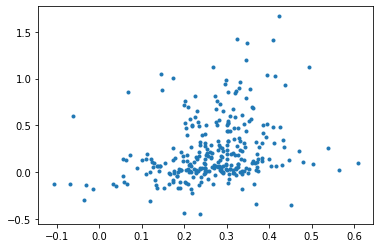

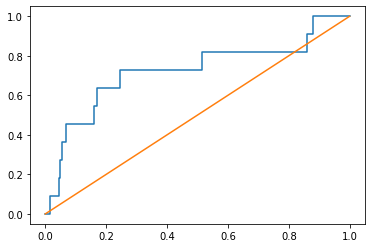

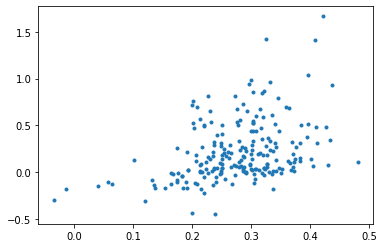

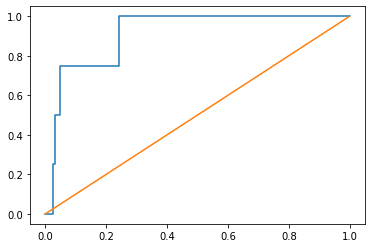

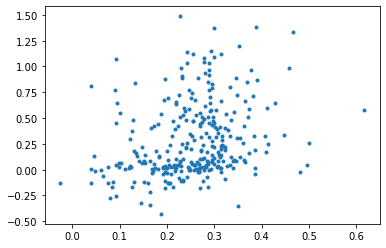

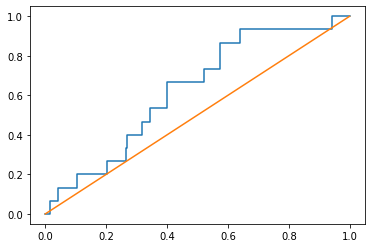

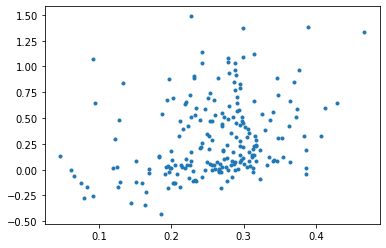

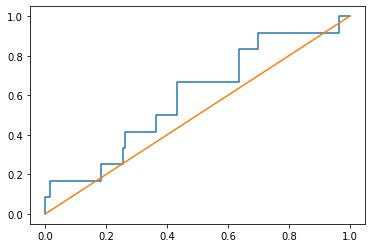

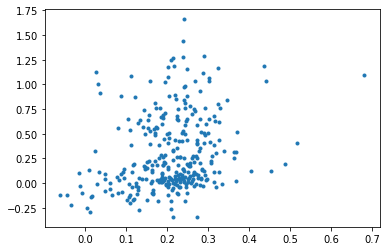

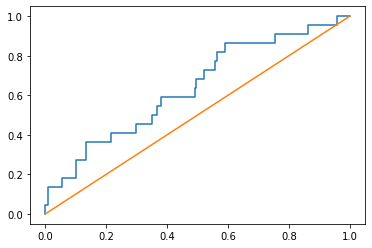

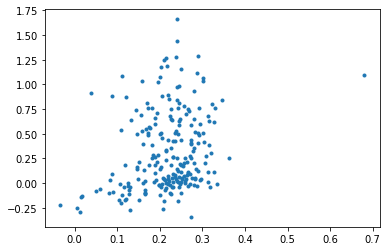

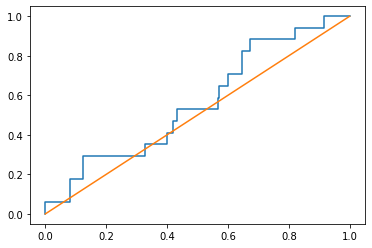

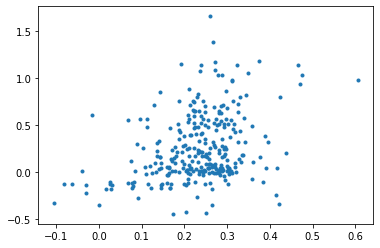

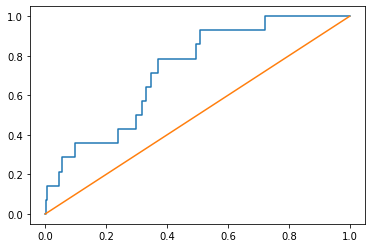

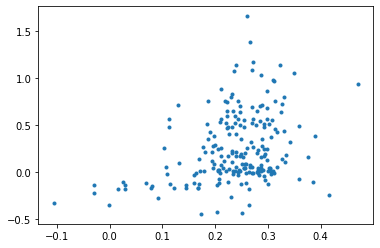

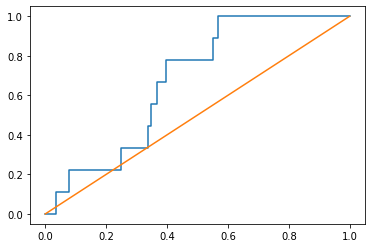

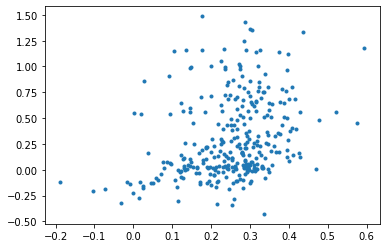

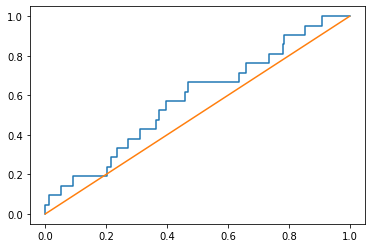

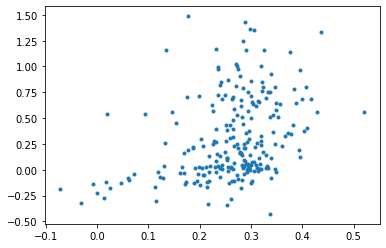

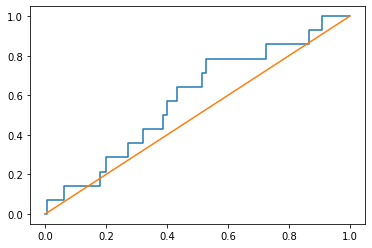

In [137]:
for i in range(5):
    optimal_model = dense_regression_model()
    optimal_epoch = optimal_epochs_norm_expression[i]
    test_x = get_normalized_2d_list(all_cv_tests[i][0])
    weights_fname = 'Model_checkpoints/norm_expression/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_model.load_weights(weights_fname)
    all_corrs_norm_expression[i], all_aucs_norm_expression[i], all_ns_norm_expression[i], good_corrs_norm_expression[i], good_aucs_norm_expression[i], good_ns_norm_expression[i] = get_performance(optimal_model.predict(np.array(test_x)),
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [138]:
print(np.mean(all_corrs_norm_expression))
print(np.mean(all_aucs_norm_expression))

print(np.mean(good_corrs_norm_expression))
print(np.mean(good_aucs_norm_expression))

print(all_aucs_norm_expression)
print(good_aucs_norm_expression)

0.29328179297560986
0.6585517236210094
0.3271116017909333
0.6659633017543768
[0.721830985915493, 0.6257683215130024, 0.6384012539184953, 0.7261904761904762, 0.5805675805675805]
[0.9130952380952381, 0.5931855500821017, 0.5630252100840336, 0.6746031746031746, 0.5859073359073359]


# "Ensemble" model: average predictions for gexp only and the full model

In [139]:
optimal_epochs

[70, 45, 115, 60, 150]

In [140]:
optimal_epochs_exp_only

[35, 65, 35, 65, 145]

In [144]:
all_aucs_ensemble = [_ for i in range(5)]
all_corrs_ensemble = [_ for i in range(5)]
all_ns_ensemble = [_ for i in range(5)]
good_aucs_ensemble = [_ for i in range(5)]
good_corrs_ensemble = [_ for i in range(5)]
good_ns_ensemble = [_ for i in range(5)]

Using all perturbagens from test set:
Pearson rho:  0.29128979399901905
AUC:  0.7071062740076823
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3650933340472676
AUC:  0.8654761904761904
n:  214


Using all perturbagens from test set:
Pearson rho:  0.3089661006219623
AUC:  0.5905437352245863
n:  297
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.39332648475274007
AUC:  0.6301313628899835
n:  215


Using all perturbagens from test set:
Pearson rho:  0.3025207852649685
AUC:  0.6974921630094044
n:  312
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.3225904312100329
AUC:  0.6280112044817927
n:  227


Using all perturbagens from test set:
Pearson rho:  0.3620272192134746
AUC:  0.7505175983436854
n:  290
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.34370595020426337
AUC:  0.6326530612244898
n:  205


Using all perturbagens from test set:
Pearson rho:  0.36590642986983046
AUC: 

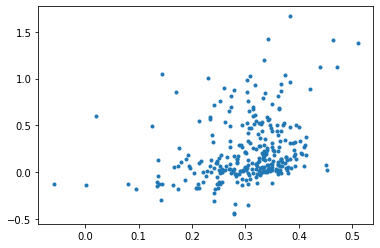

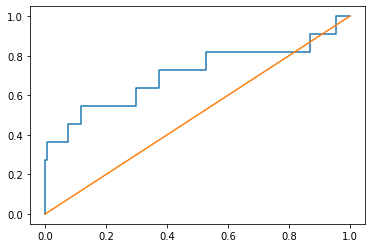

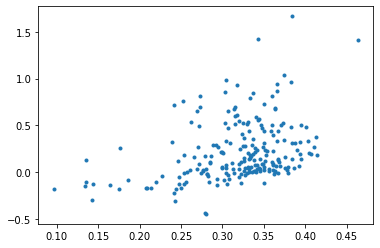

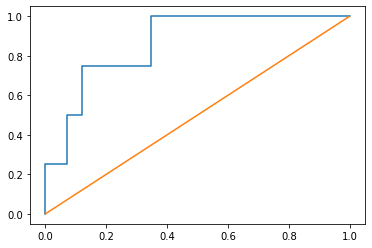

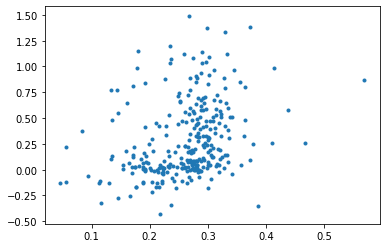

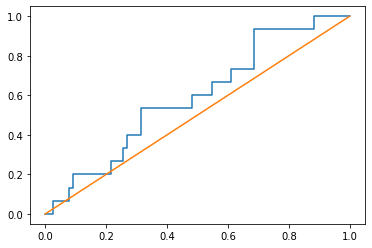

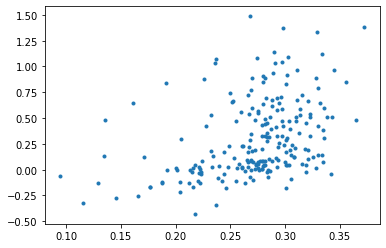

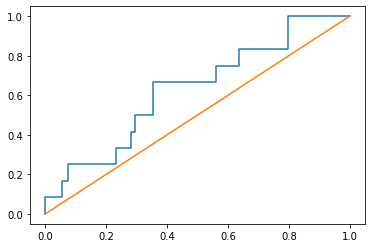

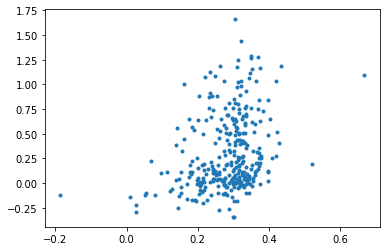

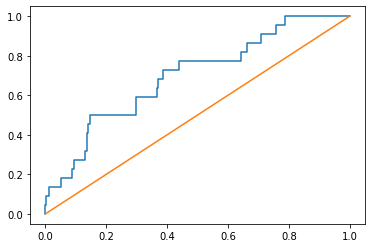

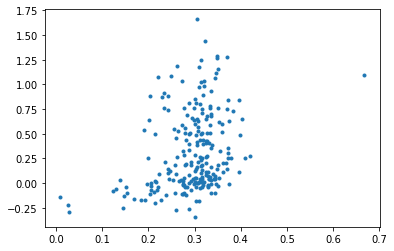

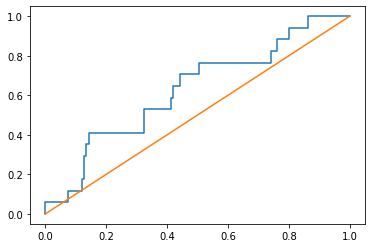

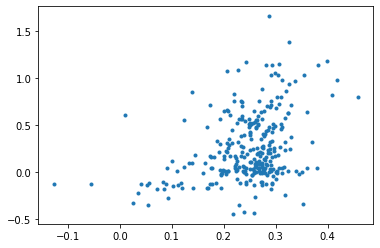

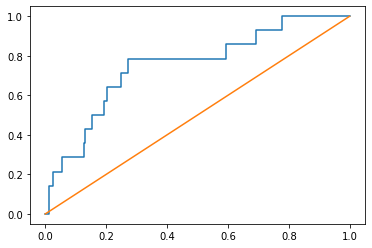

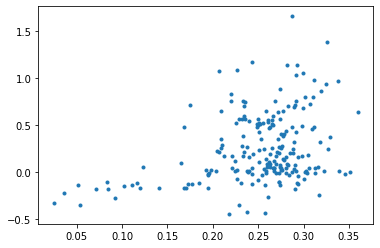

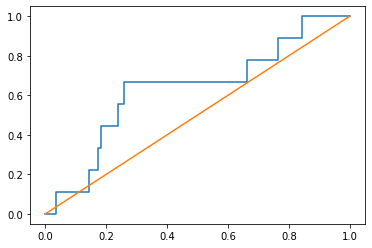

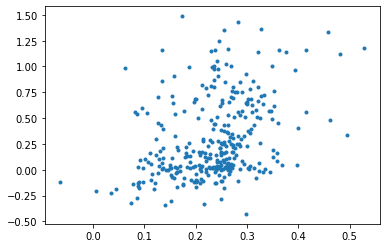

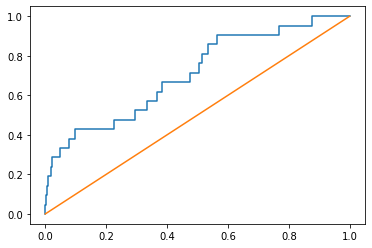

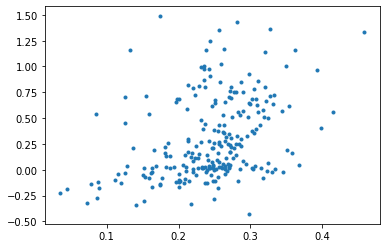

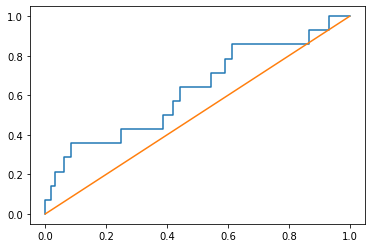

In [145]:
for i in range(5):
    # Expression only model
    optimal_exp_only_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_exp_only_model.load_weights(weights_fname)
    exp_only_predictions = optimal_exp_only_model.predict(np.array(all_cv_tests[i][0]))
    
    optimal_full_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_full_model.load_weights(weights_fname)
    full_predictions = optimal_full_model.predict([np.array(all_cv_tests[i][0]),
                                              np.array(all_cv_tests[i][4]),
                                              np.array(all_cv_tests[i][5])])
    
    averaged_predictions = [(exp_only_predictions[k]+full_predictions[k])/2 for k in range(len(full_predictions))]
    
    all_corrs_ensemble[i], all_aucs_ensemble[i], all_ns_ensemble[i], good_corrs_ensemble[i], good_aucs_ensemble[i], good_ns_ensemble[i] = get_performance(averaged_predictions,
                    all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)
    

In [146]:
print(np.mean(all_corrs_ensemble))
print(np.mean(all_aucs_ensemble))

print(np.mean(good_corrs_ensemble))
print(np.mean(good_aucs_ensemble))

print(all_aucs_ensemble)
print(good_aucs_ensemble)

0.32614206579385097
0.6907384957236132
0.3579440346688958
0.6764152389753665
[0.7071062740076823, 0.5905437352245863, 0.6974921630094044, 0.7505175983436854, 0.708032708032708]
[0.8654761904761904, 0.6301313628899835, 0.6280112044817927, 0.6326530612244898, 0.6258043758043759]


# Compare the drugs predicted well to the drugs predicted badly

In [156]:
def get_performance(predictions, y_vals, reference_df, good_cutoff = 4.5, active_cutoff = 1):
    all_corr, all_auc, all_n = get_performance_given_cutoff(predictions, y_vals, reference_df, 0.5, active_cutoff)
    return all_corr, all_auc, all_n, good_corr, good_auc, good_n

def get_performance_given_cutoff(predictions, y_vals, reference_df, n_measurements_cutoff, active_cutoff):
    predictions = [pred for pred in predictions]
    y_vals = [val for val in y_vals]
#     print('Un-averaged pearson rho: ',np.corrcoef(np.array(predictions).T, y_vals)[0][1])
    tau,pval = kendalltau(predictions, y_vals)
#     print('Un-averaged kendall tau: ', tau)
#     plt.figure()
#     plt.plot(predictions, y_vals, '.')
    averaged_predictions, actual_y_vals = average_predictions_over_measurements(predictions, y_vals, reference_df,
                                                                                n_measurements_cutoff = n_measurements_cutoff)
#     print('Averaged pearson rho: ',np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1])
    tau,pval = kendalltau(averaged_predictions, actual_y_vals)
#     print('Averaged kendall tau: ', tau)
    plt.figure()
    plt.plot(averaged_predictions, actual_y_vals, '.')
    actual_class = [1.0*(val>active_cutoff) for val in actual_y_vals]
#     print(actual_class)
#     print(averaged_predictions)
    fpr, tpr, thresholds = roc_curve(actual_class, averaged_predictions)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1])
#     print('AUC: ',roc_auc_score(actual_class, averaged_predictions))
    return np.corrcoef(np.array(averaged_predictions).T, actual_y_vals)[0][1], roc_auc_score(actual_class, averaged_predictions), len(actual_y_vals)
    
def get_averaged_predictions(predictions, y_vals, reference_df, good_cutoff = 4.5):
    all_preds, all_actual_y = average_predictions_over_measurements(predictions, y_vals, reference_df)
    good_preds, good_actual_y = average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = good_cutoff)
    return all_preds, all_actual_y, good_preds, good_actual_y
    
    
def average_predictions_over_measurements(predictions, y_vals, reference_df, n_measurements_cutoff = 0.5):
    sorted_predictions = [[] for i in range(len(reference_df))]
    averaged_predictions = []
#     actual_y_vals = reference_df.Inh_index
    actual_y_vals = []
    for i, val in enumerate(y_vals):
        index = reference_df.index[reference_df.Inh_index == val].tolist()[0]
#         if len(reference_df.index[reference_df.Inh_index == val].tolist())>1:
#             print('ERROR with val ',val)
#             for idx in reference_df.index[reference_df.Inh_index == val].tolist():
#                 print(idx)
#             return 0
        sorted_predictions[index].append(predictions[i])
    for i, pred_list in enumerate(sorted_predictions):
        if len(pred_list)>n_measurements_cutoff:
            averaged_predictions.append(np.mean(pred_list))
            actual_y_vals.append(reference_df.Inh_index[i])
#     averaged_predictions = [np.mean(sort) for sort in sorted_predictions]
#     print('SLKFJASL;KDFJSADL;KFJ\n\n')
#     print(len(averaged_predictions))
#     print(len(actual_y_vals))
#     print('\n\n\n')
    return averaged_predictions, actual_y_vals

In [157]:
all_averaged_predictions = []
all_test_y_vals = []
good_averaged_predictions = []
good_test_y_vals = []

In [158]:
for i in range(5):
    # Expression only model
    optimal_exp_only_model = dense_regression_model()
    optimal_epoch = optimal_epochs_exp_only[i]
    weights_fname = 'Model_checkpoints/expr_only/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_exp_only_model.load_weights(weights_fname)
    exp_only_predictions = optimal_exp_only_model.predict(np.array(all_cv_tests[i][0]))
    
    optimal_full_model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
    optimal_epoch = optimal_epochs[i]
    weights_fname = 'Model_checkpoints/cov2_comp/fold_'+str(i) + '/saved-model-' + str(optimal_epoch) + '.hdf5'
    optimal_full_model.load_weights(weights_fname)
    full_predictions = optimal_full_model.predict([np.array(all_cv_tests[i][0]),
                                              np.array(all_cv_tests[i][4]),
                                              np.array(all_cv_tests[i][5])])
    
    averaged_predictions = [(exp_only_predictions[k]+full_predictions[k])/2 for k in range(len(full_predictions))]
    aap, atyv, gap, gtyv = get_averaged_predictions(averaged_predictions, all_cv_tests[i][6], ref_pert_df)
    all_averaged_predictions += aap
    all_test_y_vals += atyv
    good_averaged_predictions += gap
    good_test_y_vals += gtyv
    print(i)
#     all_corrs_ensemble[i], all_aucs_ensemble[i], all_ns_ensemble[i], good_corrs_ensemble[i], good_aucs_ensemble[i], good_ns_ensemble[i] = get_performance(averaged_predictions,
#                     all_cv_tests[i][6], ref_pert_df, active_cutoff = 1)

0
1
2
3
4


In [163]:
all_averaged_predictions[0:10]

[0.30484453,
 0.2538584,
 0.342644,
 0.20313609,
 0.36527222,
 0.36196804,
 0.3647598,
 0.3149993,
 0.33400235,
 0.2507611]

In [170]:
for i,pred in enumerate(good_averaged_predictions):
    if pred > 0.45:
        print(good_test_y_vals[i])

1.4110055030000002
1.096532563
1.338431048


In [ ]:
# The 1.411 is: quinidine
# The 1.0965 is: exemestane
# The 1.338 is: atracurium

In [164]:
np.corrcoef(all_averaged_predictions, all_test_y_vals)

array([[1.        , 0.29721282],
       [0.29721282, 1.        ]])

In [165]:
np.corrcoef(good_averaged_predictions, good_test_y_vals)

array([[1.        , 0.30626242],
       [0.30626242, 1.        ]])

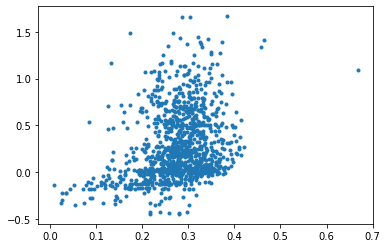

In [168]:
plt.plot(good_averaged_predictions, good_test_y_vals,'.')

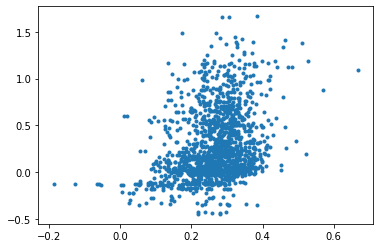

In [167]:
plt.plot(all_averaged_predictions, all_test_y_vals,'.')

# Make predictions using the ensemble model

# Normalize expression and include cell type and comparison to cov

# Pickle test and validation sets

In [121]:
import pickle
with open('Data_for_ML/Feature_variables/all_x_tests.pickle', 'wb') as f:
    pickle.dump(all_cv_tests, f)

In [171]:
with open('Data_for_ML/Feature_variables/all_x_vals.pickle', 'wb') as f:
    pickle.dump(all_cv_vals, f)

# Ignore stuff after this

In [147]:
print(np.mean(all_corrs))
print(np.mean(all_aucs))

print(np.mean(good_corrs))
print(np.mean(good_aucs))

print(all_aucs)
print(good_aucs)

0.26880176154824353
0.6464759870792987
0.3140410972439518
0.6742589586316043
[0.6565300896286813, 0.5061465721040188, 0.6426332288401254, 0.7259316770186336, 0.7011383678050345]
[0.9095238095238096, 0.5841543513957307, 0.5717086834733893, 0.6434240362811792, 0.6624839124839125]


Un-averaged pearson rho:  0.09455439709335735
Un-averaged kendall tau:  0.0659540592476606
SLKFJASL;KDFJSADL;KFJ


295
295




Averaged pearson rho:  0.20446782223048757
Averaged kendall tau:  0.1443606397323517
AUC:  0.5998719590268886
Un-averaged pearson rho:  0.09455439709335735
Un-averaged kendall tau:  0.0659540592476606
SLKFJASL;KDFJSADL;KFJ


214
214




Averaged pearson rho:  0.2672175300432335
Averaged kendall tau:  0.20249221183800623
AUC:  0.7440476190476191
Using all perturbagens from test set:
Pearson rho:  0.20446782223048757
AUC:  0.5998719590268886
n:  295
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.2672175300432335
AUC:  0.7440476190476191
n:  214


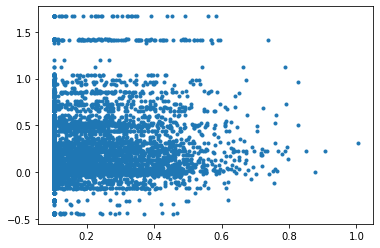

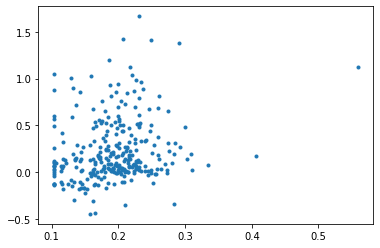

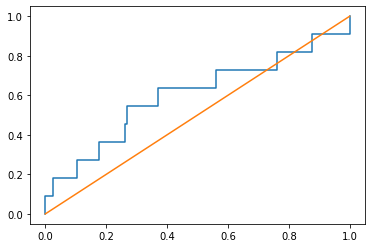

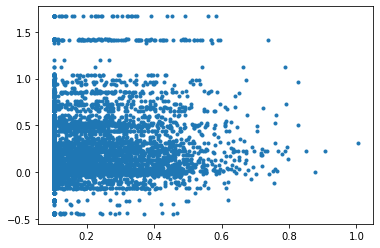

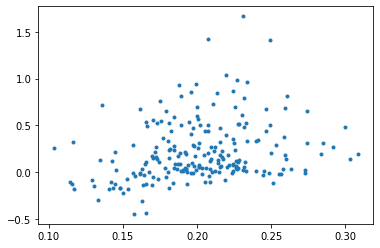

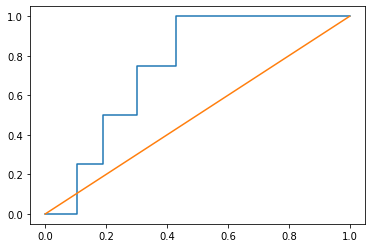

In [117]:

for i in range(1):
    get_performance(cv_models[i].predict([np.array(test_sets[i][0]),
                                   np.array(test_sets[i][2]),
                                   np.array(test_sets[i][3])]),
                    test_sets[i][4], ref_pert_df, active_cutoff)
    
    
    

In [ ]:
for = rearrange_datasets('Drug_antiviral_data/Combined_screens/Crossval_splits/fold_4/', train_df, val_df, test_df,
                                [x_train, x_train_for_cos, x_train_comp_to_cov_norm,x_train_cell, y_train],
                                [x_val, x_val_for_cos, x_val_comp_to_cov_norm,x_val_cell, y_val],
                                [x_test, x_test_for_cos, x_test_comp_to_cov_norm,x_test_cell, y_test],
                                              merge_train_and_val=True)

In [529]:
# model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
model = all_dense_model(use_gexp = True, use_gexp_comp = True, use_cos = False, gexp_input_dim = 12328)
# model = all_dense_model(use_gexp = True, use_gexp_comp = False, use_cos = True, gexp_input_dim = 12328)

In [530]:
model.summary()

Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_148 (InputLayer)          (None, 6, 278)       0                                            
__________________________________________________________________________________________________
input_147 (InputLayer)          (None, 12328)        0                                            
__________________________________________________________________________________________________
flatten_41 (Flatten)            (None, 1668)         0           input_148[0][0]                  
__________________________________________________________________________________________________
input_149 (InputLayer)          (None, 70)           0                                            
___________________________________________________________________________________________

In [531]:
# model.fit([np.array(x_train_for_cos), np.array(x_train_comp_to_cov_norm), np.array(x_train_cell)],y_train,
#           batch_size = 128, epochs = 20,
#           validation_data = ([np.array(x_val_for_cos), np.array(x_val_comp_to_cov_norm), np.array(x_val_cell)], y_val,np.array(val_weights)),
#          sample_weight = np.array(train_weights), 
#          shuffle = True)
# model.fit([np.array(x_train), np.array(x_train_comp_to_cov_norm), np.array(x_train_cell)],y_train,
#           batch_size = 64, epochs = 20,
#           validation_data = ([np.array(x_val), np.array(x_val_comp_to_cov_norm), np.array(x_val_cell)], y_val,np.array(val_weights)),
#          sample_weight = np.array(train_weights), 
#          shuffle = True)
# model.fit([np.array(x_train), np.array(x_train_comp_to_cov_norm), np.array(x_train_cell)],y_train,
#           batch_size = 64, epochs = 20,
#          sample_weight = np.array(train_weights), 
#          shuffle = True)
model.fit([np.concatenate((np.array(x_train), np.array(x_val))),
           np.concatenate((x_train_comp_to_cov_norm, x_val_comp_to_cov_norm)),
           np.concatenate((x_train_cell, x_val_cell))],
          np.concatenate((y_train, y_val)),
          batch_size = 64, epochs = 20,
         sample_weight = np.concatenate((train_weights, val_weights)), 
         shuffle = True)
# model.fit([np.array(x_train), np.array(x_train_cell)],y_train,
#           batch_size = 128, epochs = 50,
#           validation_data = ([np.array(x_val), np.array(x_val_cell)], y_val,np.array(val_weights)),
#          sample_weight = np.array(train_weights), 
#          shuffle = True)
# model.fit([np.array(x_train), np.array(x_train_cosine_abs), np.array(x_train_cell)],y_train,
#           batch_size = 64, epochs = 100,
#           validation_data = ([np.array(x_val), np.array(x_val_cosine_abs), np.array(x_val_cell)],
#                              y_val,np.array(val_weights)),
#          sample_weight = np.array(train_weights), 
#          shuffle = True)
# x_train_comp_to_cov_norm

Epoch 1/20
26313/26313 [==============================] - 15s 589us/step - loss: 0.3716
Epoch 2/20
26313/26313 [==============================] - 9s 352us/step - loss: 0.0506
Epoch 3/20
26313/26313 [==============================] - 12s 439us/step - loss: 0.0212
Epoch 4/20
26313/26313 [==============================] - 9s 356us/step - loss: 0.0147
Epoch 5/20
26313/26313 [==============================] - 10s 364us/step - loss: 0.01000s - 
Epoch 6/20
26313/26313 [==============================] - 9s 358us/step - loss: 0.0088
Epoch 7/20
26313/26313 [==============================] - 9s 355us/step - loss: 0.0070
Epoch 8/20
26313/26313 [==============================] - 9s 355us/step - loss: 0.0078
Epoch 9/20
26313/26313 [==============================] - 11s 423us/step - loss: 0.0061
Epoch 10/20
26313/26313 [==============================] - 11s 411us/step - loss: 0.0090
Epoch 11/20
26313/26313 [==============================] - 11s 405us/step - loss: 0.0058
Epoch 12/20
26313/26313 [=====

Un-averaged pearson rho:  0.12126173253290472
Un-averaged kendall tau:  0.09284144923214827
SLKFJASL;KDFJSADL;KFJ


246
246




Averaged pearson rho:  0.30839143616488446
Averaged kendall tau:  0.272312465815911
AUC:  0.6421663442940039
Un-averaged pearson rho:  0.12126173253290472
Un-averaged kendall tau:  0.09284144923214827
SLKFJASL;KDFJSADL;KFJ


183
183




Averaged pearson rho:  0.35638139995808454
Averaged kendall tau:  0.28716408960549844
AUC:  0.6052023121387283
Using all perturbagens from test set:
Pearson rho:  0.30839143616488446
AUC:  0.6421663442940039
n:  246
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.35638139995808454
AUC:  0.6052023121387283
n:  183


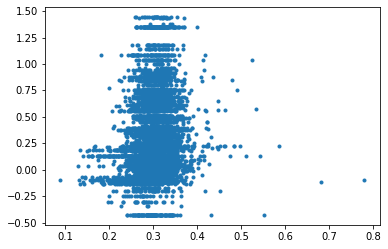

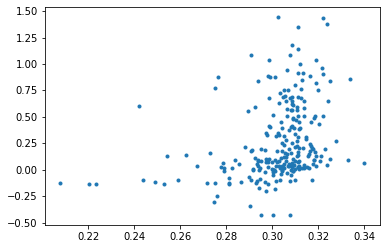

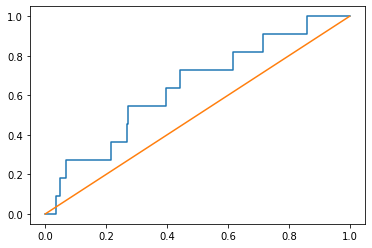

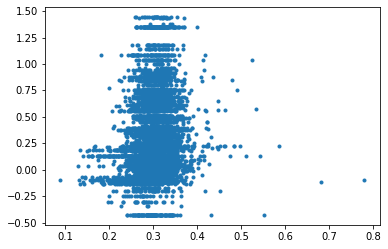

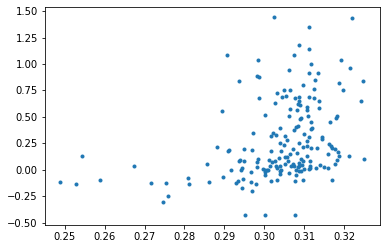

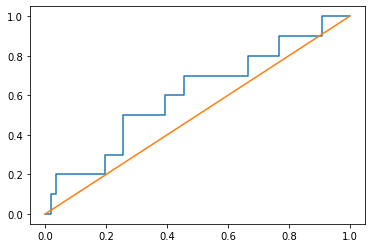

In [532]:
get_performance(model.predict([np.array(x_val),np.array(x_val_comp_to_cov_norm), np.array(x_val_cell)]),
                y_val, val_pert_df)

Un-averaged pearson rho:  0.10881612880359745
Un-averaged kendall tau:  0.0717764269641521
SLKFJASL;KDFJSADL;KFJ


242
242




Averaged pearson rho:  0.2077747133233017
Averaged kendall tau:  0.1426219951304825
AUC:  0.7197953561589925
Un-averaged pearson rho:  0.10881612880359745
Un-averaged kendall tau:  0.0717764269641521
SLKFJASL;KDFJSADL;KFJ


179
179




Averaged pearson rho:  0.24065914126405347
Averaged kendall tau:  0.14556525014123406
AUC:  0.7375730994152047
Using all perturbagens from test set:
Pearson rho:  0.2077747133233017
AUC:  0.7197953561589925
n:  242
Using only perturbagens with at least  4.5  measurements:
Pearson rho:  0.24065914126405347
AUC:  0.7375730994152047
n:  179


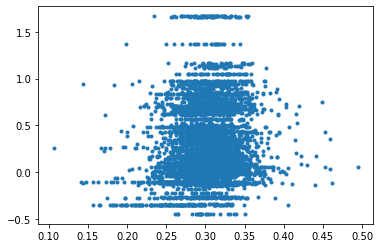

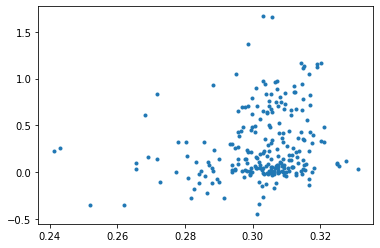

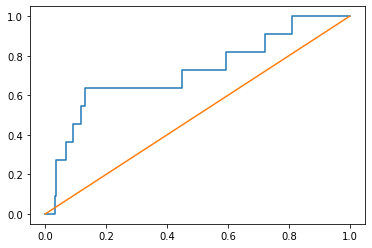

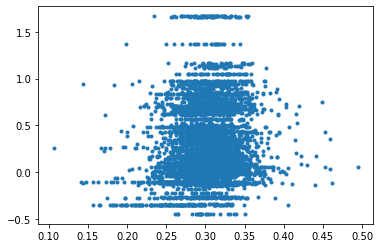

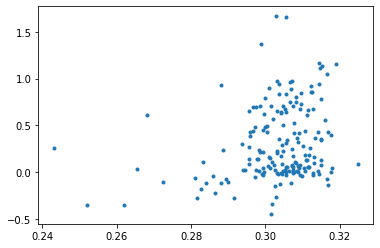

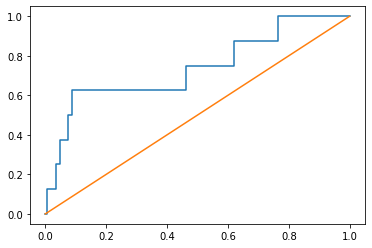

In [533]:
get_performance(model.predict([np.array(x_test),np.array(x_test_comp_to_cov_norm), np.array(x_test_cell)]), y_test, test_pert_df)

Un-averaged pearson rho:  0.12810622945802763
Un-averaged kendall tau:  0.0826708498862849
Averaged pearson rho:  0.3177181258515173
Averaged kendall tau:  0.24717058914007223
AUC:  0.79456906729634


(0.3177181258515173, 0.79456906729634)

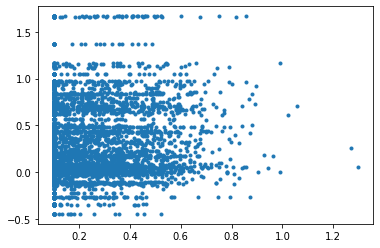

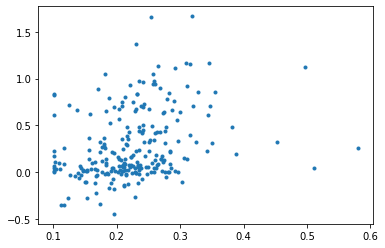

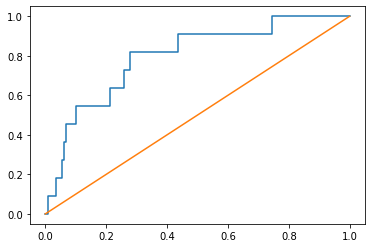

In [441]:
get_performance(model.predict([np.array(x_test),np.array(x_test_comp_to_cov_norm), np.array(x_test_cell)]), y_test, test_pert_df)

In [872]:
model.fit([np.array(x_train), np.array(x_train_cosine), np.array(x_train_cell)],y_train,batch_size = 64, epochs = 100,
          validation_data = ([np.array(x_val), np.array(x_val_cosine), np.array(x_val_cell)], y_val,np.array(val_weights)),
         sample_weight = np.array(train_weights), 
         shuffle = True)

Train on 19014 samples, validate on 7299 samples
Epoch 1/100
19014/19014 [==============================] - 8s 413us/step - loss: 0.0042 - val_loss: 0.0052
Epoch 2/100
19014/19014 [==============================] - 7s 374us/step - loss: 0.0038 - val_loss: 0.0046
Epoch 3/100
19014/19014 [==============================] - 10s 504us/step - loss: 0.0036 - val_loss: 0.0051
Epoch 4/100
19014/19014 [==============================] - 8s 403us/step - loss: 0.0036 - val_loss: 0.0048
Epoch 5/100
19014/19014 [==============================] - 7s 373us/step - loss: 0.0039 - val_loss: 0.0050
Epoch 6/100
19014/19014 [==============================] - 7s 375us/step - loss: 0.0035 - val_loss: 0.0048
Epoch 7/100
19014/19014 [==============================] - 7s 376us/step - loss: 0.0035 - val_loss: 0.0049
Epoch 8/100
19014/19014 [==============================] - 7s 375us/step - loss: 0.0036 - val_loss: 0.0048
Epoch 9/100
19014/19014 [==============================] - 7s 374us/step - loss: 0.0036 - val_

Un-averaged pearson rho:  0.07257745142956527
Un-averaged kendall tau:  0.07367737388339524
Averaged pearson rho:  0.14230881586507377
Averaged kendall tau:  0.10542558486809357
AUC:  0.5390953716690042


(0.14230881586507377, 0.5390953716690042)

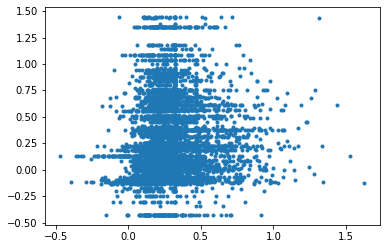

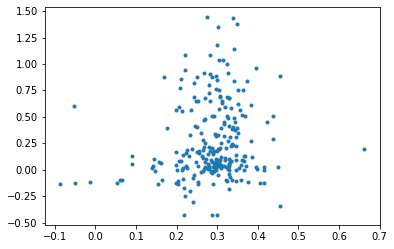

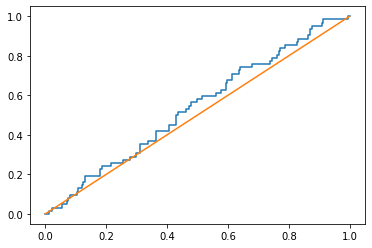

In [873]:
get_performance(model.predict([np.array(x_val), np.array(x_val_cosine), np.array(x_val_cell)]), y_val, val_pert_df)

Un-averaged pearson rho:  0.14294447441098304
Un-averaged kendall tau:  0.1148225042037113
Averaged pearson rho:  0.24614880174500434
Averaged kendall tau:  0.20537704468296697
AUC:  0.5984820089955023


(0.24614880174500434, 0.5984820089955023)

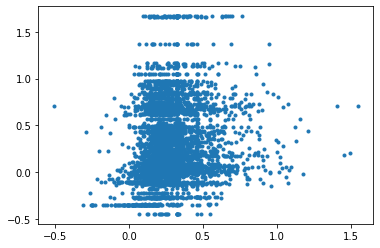

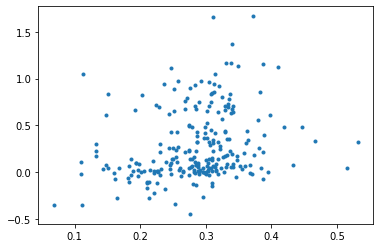

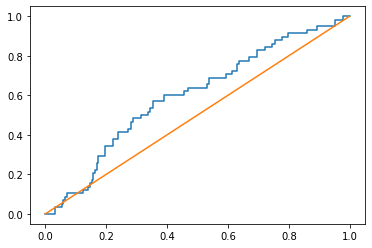

In [874]:
get_performance(model.predict([np.array(x_test), np.array(x_test_cosine), np.array(x_test_cell)]), y_test, test_pert_df)

In [698]:
model = dense_regression_model_with_dose_and_cell_id(gexp_input_dim = 278)

In [699]:
model.fit([x_train_for_cos, x_train_dose,x_train_cell],y_train,batch_size = 64, epochs = 40,
          validation_data = ([x_val_for_cos,x_val_dose,x_val_cell],y_val,np.array(val_weights)),
         sample_weight = np.array(train_weights), 
         shuffle = True)

Train on 19014 samples, validate on 7299 samples
Epoch 1/40
19014/19014 [==============================] - 7s 350us/step - loss: 0.0062 - val_loss: 0.0046
Epoch 2/40
19014/19014 [==============================] - 3s 156us/step - loss: 0.0050 - val_loss: 0.0046
Epoch 3/40
19014/19014 [==============================] - 3s 157us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 4/40
19014/19014 [==============================] - 3s 161us/step - loss: 0.0046 - val_loss: 0.0048
Epoch 5/40
19014/19014 [==============================] - 3s 156us/step - loss: 0.0045 - val_loss: 0.0046
Epoch 6/40
19014/19014 [==============================] - 3s 163us/step - loss: 0.0043 - val_loss: 0.0048
Epoch 7/40
19014/19014 [==============================] - 3s 155us/step - loss: 0.0041 - val_loss: 0.0048
Epoch 8/40
19014/19014 [==============================] - 3s 173us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 9/40
19014/19014 [==============================] - 3s 180us/step - loss: 0.0038 - val_loss: 0.00

Un-averaged pearson rho:  0.09299049970517052
Un-averaged kendall tau:  0.08079148764266691
Averaged pearson rho:  0.244585319945104
Averaged kendall tau:  0.2118798739007798
AUC:  0.6170212765957446


(0.244585319945104, 0.6170212765957446)

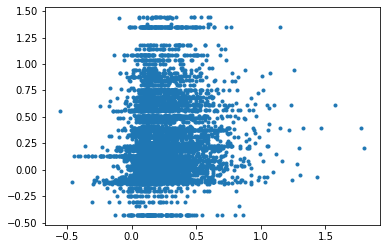

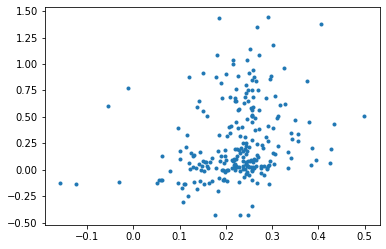

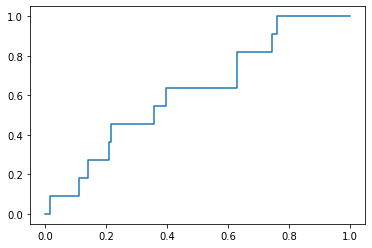

In [700]:
get_performance(model.predict([x_val_for_cos, x_val_dose, x_val_cell]), y_val, val_pert_df)

Un-averaged pearson rho:  0.11160953572972
Un-averaged kendall tau:  0.09931368459777964
Averaged pearson rho:  0.2750502456815003
Averaged kendall tau:  0.1980384760467748
AUC:  0.6288862652499017


(0.2750502456815003, 0.6288862652499017)

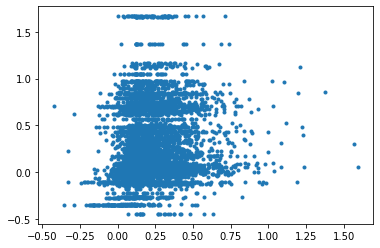

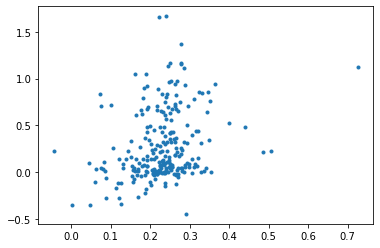

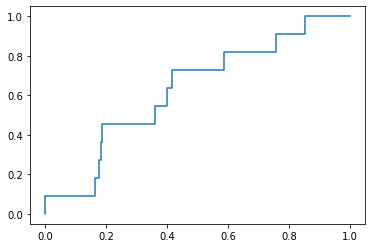

In [701]:
get_performance(model.predict([x_test_for_cos, x_test_dose, x_test_cell]), y_test, test_pert_df)

In [747]:
model = dense_regression_model_with_dose_and_cell_id()

In [748]:
model.fit([x_train, x_train_dose,x_train_cell],y_train,batch_size = 64, epochs = 20,
          validation_data = ([x_val,x_val_dose,x_val_cell],y_val,np.array(val_weights)),
         sample_weight = np.array(train_weights), 
         shuffle = True)

Train on 19014 samples, validate on 7299 samples
Epoch 1/20
 9920/19014 [==============>...............] - ETA: 11s - loss: 0.0529

KeyboardInterrupt: 

Un-averaged pearson rho:  0.08094191192518926
Un-averaged kendall tau:  0.09825919485750732
Averaged pearson rho:  0.20249129146113815
Averaged kendall tau:  0.18227974116475856
AUC:  0.590715667311412


(0.20249129146113815, 0.590715667311412)

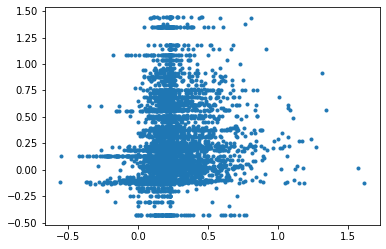

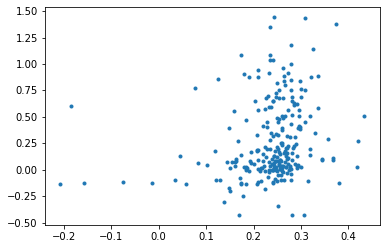

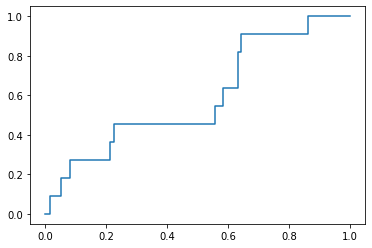

In [525]:
get_performance(model.predict([x_val, x_val_dose, x_val_cell]), y_val, val_pert_df)

Un-averaged pearson rho:  0.16816451702147994
Un-averaged kendall tau:  0.12909973133255082
Averaged pearson rho:  0.30900517295084046
Averaged kendall tau:  0.24069819279174237
AUC:  0.641086186540732


(0.30900517295084046, 0.641086186540732)

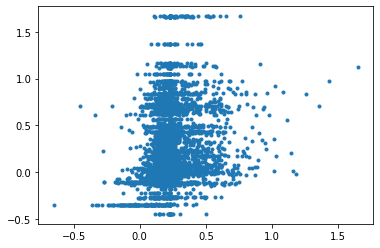

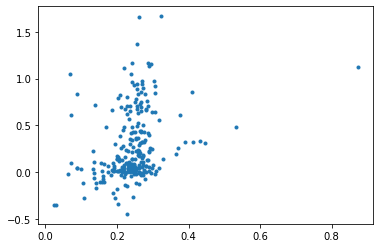

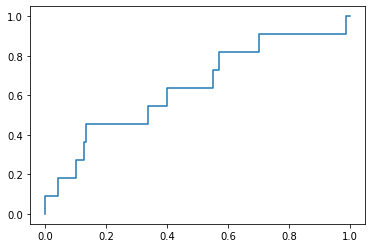

In [526]:
get_performance(model.predict([x_test, x_test_dose, x_test_cell]), y_test, test_pert_df)

In [499]:
# model = dense_model_with_cell_id_and_dose()
model = dense_regression_model_with_dose()

In [506]:
model.fit([x_train, x_train_dose],y_train,batch_size = 64, epochs = 20,
          validation_data = ([x_val,x_val_dose],y_val,np.array(val_weights)),
         sample_weight = np.array(train_weights), 
         shuffle = True)

Train on 19014 samples, validate on 7299 samples
Epoch 1/20
19014/19014 [==============================] - 8s 438us/step - loss: 0.0049 - val_loss: 0.0045
Epoch 2/20
19014/19014 [==============================] - 8s 409us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/20
19014/19014 [==============================] - 9s 448us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 4/20
19014/19014 [==============================] - 9s 463us/step - loss: 0.0046 - val_loss: 0.0045
Epoch 5/20
19014/19014 [==============================] - 8s 415us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 6/20
19014/19014 [==============================] - 8s 442us/step - loss: 0.0044 - val_loss: 0.0047
Epoch 7/20
19014/19014 [==============================] - 8s 402us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 8/20
19014/19014 [==============================] - 9s 466us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 9/20
19014/19014 [==============================] - 8s 414us/step - loss: 0.0042 - val_loss: 0.00

Un-averaged pearson rho:  0.08077063137750584
Un-averaged kendall tau:  0.08446703535439937
Averaged pearson rho:  0.1759985938731506
Averaged kendall tau:  0.15188319230131078
AUC:  0.5748549323017408


(0.1759985938731506, 0.5748549323017408)

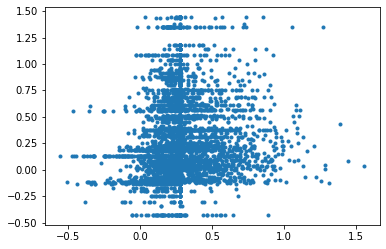

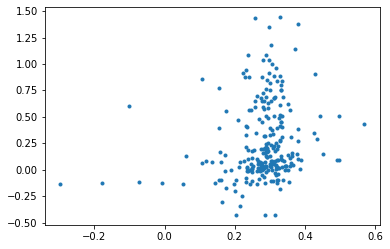

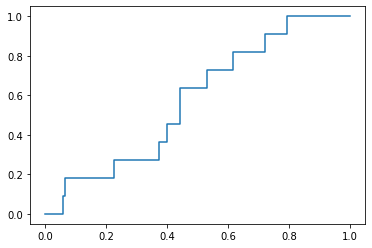

In [507]:
get_performance(model.predict([x_val, x_val_dose]), y_val, val_pert_df)

Un-averaged pearson rho:  0.1584944438826342
Un-averaged kendall tau:  0.14214555807382553
Averaged pearson rho:  0.2722499322730152
Averaged kendall tau:  0.2384046913126301
AUC:  0.5733963006690279


(0.2722499322730152, 0.5733963006690279)

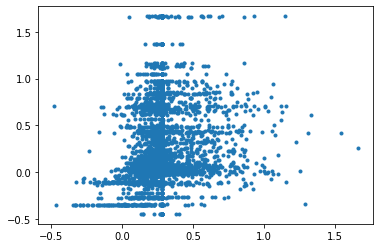

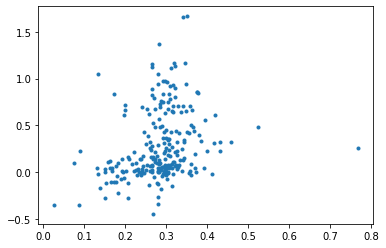

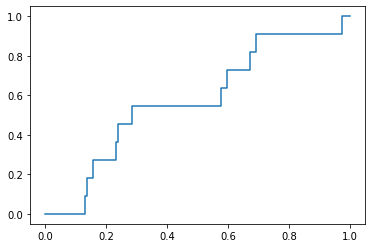

In [508]:
get_performance(model.predict([x_test, x_test_dose]), y_test, test_pert_df)

In [291]:
model.fit([x_train, x_train_cell, x_train_dose],y_train,batch_size = 64, epochs = 20,
          validation_data = ([x_val,x_val_cell,x_val_dose],y_val,np.array(val_weights)),
         sample_weight = np.array(train_weights), callbacks = [early_stopping])

Train on 19014 samples, validate on 7299 samples
Epoch 1/20
19014/19014 [==============================] - 5s 269us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 2/20
19014/19014 [==============================] - 5s 261us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 3/20
19014/19014 [==============================] - 5s 271us/step - loss: 0.0081 - val_loss: 0.0068
Epoch 4/20
 1856/19014 [=>............................] - ETA: 4s - loss: 0.0081

KeyboardInterrupt: 

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Un-averaged pearson rho:  nan
Un-averaged kendall tau:  nan
Averaged pearson rho:  nan
Averaged kendall tau:  nan
AUC:  0.5


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(nan, 0.5)

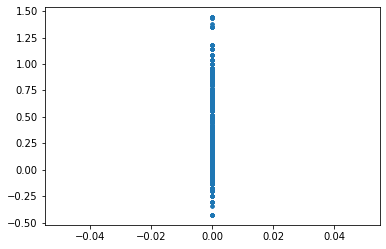

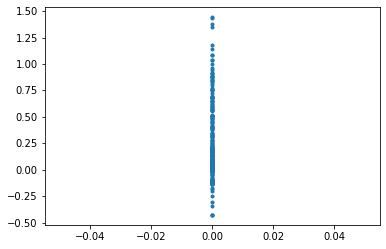

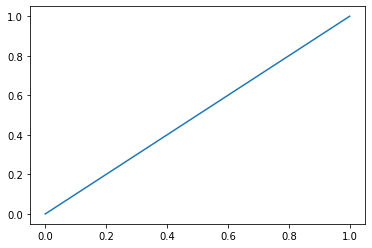

In [289]:
get_performance(model.predict([x_val, x_val_cell, x_val_dose]), y_val, val_pert_df)

In [386]:
model = dense_regression_model_with_formulations(struc_input_dim = 12328)

In [387]:
model.summary()

Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 8)            0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           (None, 12328)        0                                            
__________________________________________________________________________________________________
dense_199 (Dense)               (None, 8)            72          input_67[0][0]                   
__________________________________________________________________________________________________
dense_201 (Dense)               (None, 100)          1232900     input_68[0][0]                   
___________________________________________________________________________________________

In [376]:
model = dense_regression_model(dropout = 0.1)

In [377]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 100)               1232900   
_________________________________________________________________
dropout_32 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_188 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_189 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_190 (Dense)            (None, 1)                 21        
Total params: 1,245,041
Trainable params: 1,245,041
Non-trainable params: 0
___________________________________________

In [479]:
model = dense_model_api()
model = dense_regression_model()

In [480]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_366 (Dense)            (None, 100)               1232900   
_________________________________________________________________
dropout_73 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_367 (Dense)            (None, 100)               10100     
_________________________________________________________________
dropout_74 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_368 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_369 (Dense)            (None, 1)                 21        
Total params: 1,245,041
Trainable params: 1,245,041
Non-trainable params: 0
___________________________________________

In [490]:
model.fit(x_train, y_train, batch_size = 64, epochs = 40,
          validation_data = (x_val,y_val,np.array(val_weights)), sample_weight = np.array(train_weights),
         shuffle = True)

Train on 19014 samples, validate on 7299 samples
Epoch 1/40
19014/19014 [==============================] - 7s 373us/step - loss: 0.0011 - val_loss: 0.0057
Epoch 2/40
19014/19014 [==============================] - 8s 427us/step - loss: 0.0010 - val_loss: 0.0054
Epoch 3/40
19014/19014 [==============================] - 8s 432us/step - loss: 9.9926e-04 - val_loss: 0.0057
Epoch 4/40
19014/19014 [==============================] - 6s 338us/step - loss: 9.5128e-04 - val_loss: 0.0055
Epoch 5/40
19014/19014 [==============================] - 6s 325us/step - loss: 0.0010 - val_loss: 0.0056
Epoch 6/40
19014/19014 [==============================] - 7s 346us/step - loss: 0.0012 - val_loss: 0.0054
Epoch 7/40
19014/19014 [==============================] - 6s 329us/step - loss: 0.0010 - val_loss: 0.0055
Epoch 8/40
19014/19014 [==============================] - 6s 335us/step - loss: 0.0016 - val_loss: 0.0056
Epoch 9/40
19014/19014 [==============================] - 6s 332us/step - loss: 0.0011 - val_lo

Un-averaged pearson rho:  0.08656215427881139
Un-averaged kendall tau:  0.07658880315988564
Averaged pearson rho:  0.20216309546539632
Averaged kendall tau:  0.17192633150821304
AUC:  0.5911025145067699


(0.20216309546539632, 0.5911025145067699)

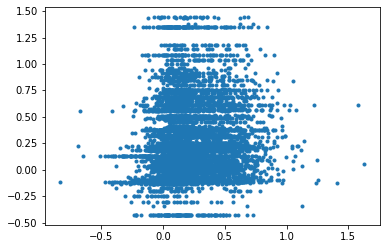

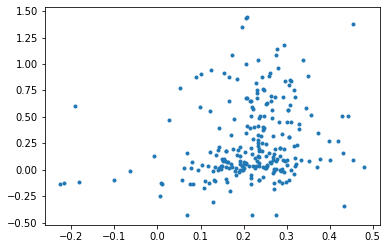

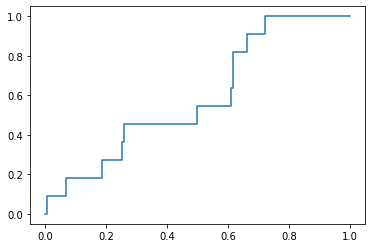

In [491]:
get_performance(model.predict(x_val), y_val, val_pert_df)

Un-averaged pearson rho:  0.13858000348417832
Un-averaged kendall tau:  0.11064458281627831
Averaged pearson rho:  0.31622981580647297
Averaged kendall tau:  0.2437159219505504
AUC:  0.7044470680834318


(0.31622981580647297, 0.7044470680834318)

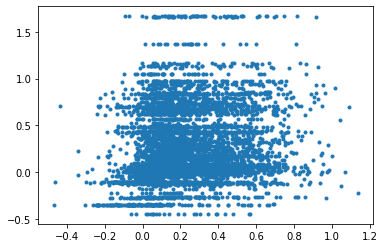

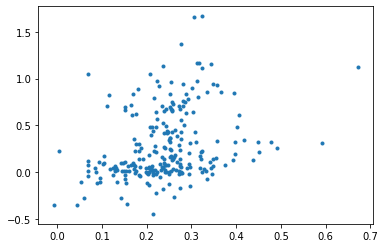

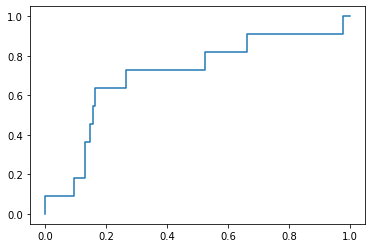

In [492]:
get_performance(model.predict(x_test), y_test, test_pert_df)

Un-averaged pearson rho:  0.09949119328176506
Un-averaged kendall tau:  0.09190102563393483
Averaged pearson rho:  0.217238977909613
Averaged kendall tau:  0.1738510038161606
AUC:  0.6235976789168278


(0.217238977909613, 0.6235976789168278)

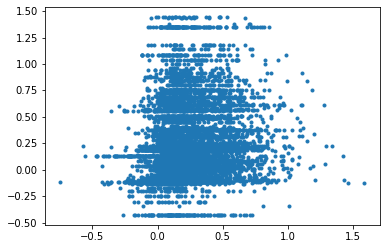

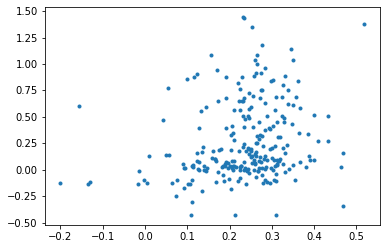

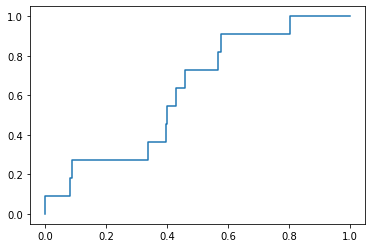

In [488]:
get_performance(model.predict(x_val), y_val, val_pert_df)

Un-averaged pearson rho:  0.15426187752286516
Un-averaged kendall tau:  0.11667624130142058
Averaged pearson rho:  0.3411949561873433
Averaged kendall tau:  0.24892836322485512
AUC:  0.7520661157024794


(0.3411949561873433, 0.7520661157024794)

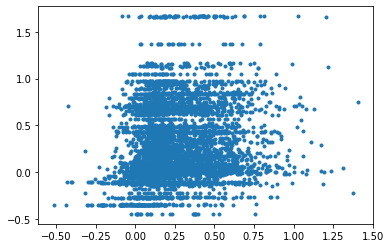

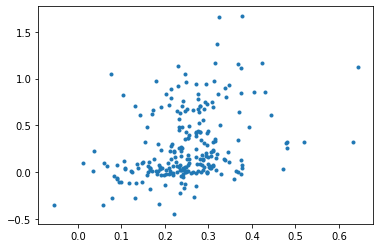

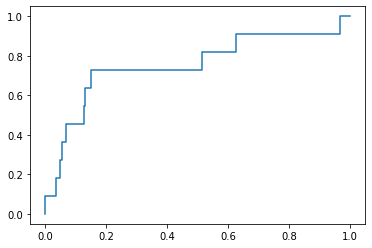

In [489]:
get_performance(model.predict(x_test), y_test, test_pert_df)

# Generating coronavirus dataframe

In [841]:
l5_df = pd.read_csv('Data_for_ML/level5_1000.csv')
header = 'Data_for_ML/Coronavirus_infected_host_gene_expression/Curated/'
fnames = os.listdir(header)
gexp_profile_dict = {'rid':l5_df.rid}
for idx, fname in enumerate(fnames):
    if fname.split('_')[0] == 'Averaged':
        print(fname)
        gse_num = fname.split('.')[0].split('_')[-1]
        cov_gexp_df = pd.read_csv(header + fname)
        if gse_num == 'GSE68820':
            print(list(cov_gexp_df.columns))
            print(cov_gexp_df.head())
        col_names = list(cov_gexp_df.columns)
        col_names.remove('GENE_SYMBOL')
        col_names.remove('GENE_ID')
        cov_gene_ids = []
        for cov_gene_id in cov_gexp_df.GENE_ID:
            try:
                to_add = int(cov_gene_id)
                cov_gene_ids.append(to_add)
            except:
                cov_gene_ids.append(-1)
#         cov_gene_ids = [int(val) if not 'NaN' in val else -1 for val in cov_gexp_df.GENE_ID ]
        for col_name in col_names:
            gexp_profile_dict[gse_num + '_' + col_name] = [None for _ in range(len(l5_df))]
        for i,gene_id in enumerate(l5_df.rid):
            if gene_id in cov_gene_ids:
                ind = cov_gene_ids.index(gene_id)
                for col_name in col_names:
                    gexp_profile_dict[gse_num + '_' + col_name][i] = cov_gexp_df[col_name][ind]

            

Averaged_with_human_ID_GSE68820.csv
['GENE_SYMBOL', 'SARS_mouse_adapted_2dpi_log2_fc', 'GENE_ID']
     GENE_SYMBOL  SARS_mouse_adapted_2dpi_log2_fc  GENE_ID
0         Hivep3                         0.584542  59269.0
1         Mif4gd                         0.156575  57409.0
2           Lnx1                        -0.343932  84708.0
3            NaN                        -0.074866      NaN
4  2610002J23Rik                        -0.229598      NaN
Averaged_with_human_ID_GSE47960.csv
Averaged_with_human_ID_GSE17400.csv
Averaged_with_human_ID_GSE147507_series_5.csv
Averaged_with_human_ID_GSE100504.csv
Averaged_with_human_ID_GSE47961.csv
Averaged_with_human_ID_GSE56677.csv
Averaged_with_human_ID_GSE147507_series_7.csv
Averaged_with_human_ID_GSE147507_series_6.csv
Averaged_with_human_ID_GSE47962.csv
Averaged_with_human_ID_GSE81909.csv
Averaged_with_human_ID_GSE147507_series_2.csv
Averaged_with_human_ID_GSE59185.csv
Averaged_with_human_ID_GSE86530.csv
Averaged_with_human_ID_GSE89167.csv
Ave

In [842]:
all_gexp_profiles = pd.DataFrame.from_dict(gexp_profile_dict)
all_gexp_profiles.to_csv('Data_for_ML/Coronavirus_infected_host_gene_expression/host_gexp.csv',index = False)
all_gexp_profiles.corr()

,rid,GSE68820_SARS_mouse_adapted_2dpi_log2_fc,GSE47960_BAT_24hr_log2_fc,GSE47960_SARS_24hr_log2_fc,GSE17400_SARS_24_hours_log2_fc,5_GSE147507_Series5_log2_fc,GSE100504_MERS_24hr_log2_fc,GSE47961_BAT_24hr_log2_fc,GSE47961_SARS_24hr_log2_fc,GSE56677_LoCovMERS_18hr_log2_fc,...,GSE86529_MERS_24hr_log2_fc,GSE108594_MERS_1e4_2dpi_log2_fc,GSE108594_MERS_1e5_2dpi_log2_fc,GSE108594_MERS_1e6_2dpi_log2_fc,GSE86528_MERS_24hr_log2_fc,15_GSE147507_Series15_log2_fc,GSE100496_MERS_24hr_log2_fc,GSE100509_MERS_24hr_log2_fc,GSE79458_MERS_24hr_log2_fc,16_GSE147507_Series16_log2_fc
rid,1.000000,0.006669,0.005989,0.008818,0.014690,0.010778,-0.013488,0.006298,0.005629,0.006991,...,-0.001710,0.004231,0.004913,0.005767,-0.000777,-0.008430,-0.010196,-0.000010,0.000276,0.022376
GSE68820_SARS_mouse_adapted_2dpi_log2_fc,0.006669,1.000000,0.025498,-0.010461,0.093214,0.063722,0.148148,-0.076868,-0.031434,0.171566,...,0.122937,0.755213,0.794241,0.762428,0.094015,0.229052,0.045244,0.105739,0.078040,0.263035
GSE47960_BAT_24hr_log2_fc,0.005989,0.025498,1.000000,0.759101,0.184599,-0.068297,0.420333,0.295082,0.249472,0.072523,...,0.119090,-0.002573,-0.015794,-0.027267,0.067945,-0.118844,0.141488,0.133648,0.118289,0.090034
GSE47960_SARS_24hr_log2_fc,0.008818,-0.010461,0.759101,1.000000,0.127280,-0.181964,0.421221,0.391728,0.341571,0.014623,...,0.056936,-0.031132,-0.040968,-0.057849,0.022502,-0.154139,0.143449,0.084193,0.074817,-0.005593
GSE17400_SARS_24_hours_log2_fc,0.014690,0.093214,0.184599,0.127280,1.000000,0.068224,0.143647,0.026749,0.072139,0.142557,...,0.178915,0.078731,0.067478,0.061128,0.084837,0.047698,0.085377,0.181174,0.126886,0.182229
5_GSE147507_Series5_log2_fc,0.010778,0.063722,-0.068297,-0.181964,0.068224,1.000000,-0.038482,-0.052515,-0.071167,0.126817,...,0.075130,0.073645,0.075445,0.095850,0.041305,0.104628,-0.064615,0.125682,0.039342,0.365058
GSE100504_MERS_24hr_log2_fc,-0.013488,0.148148,0.420333,0.421221,0.143647,-0.038482,1.000000,0.078651,0.070332,0.376998,...,0.330719,0.137616,0.117356,0.097586,0.402900,-0.002449,0.364022,0.351586,0.417232,0.222332
GSE47961_BAT_24hr_log2_fc,0.006298,-0.076868,0.295082,0.391728,0.026749,-0.052515,0.078651,1.000000,0.741622,0.030300,...,-0.018593,-0.040214,-0.050333,-0.057412,0.003718,-0.089820,0.059907,0.026704,0.020228,0.064047
GSE47961_SARS_24hr_log2_fc,0.005629,-0.031434,0.249472,0.341571,0.072139,-0.071167,0.070332,0.741622,1.000000,0.026466,...,0.025342,0.000502,-0.005392,-0.008415,0.046072,-0.059387,0.034985,0.040512,0.040235,0.071188
GSE56677_LoCovMERS_18hr_log2_fc,0.006991,0.171566,0.072523,0.014623,0.142557,0.126817,0.376998,0.030300,0.026466,1.000000,...,0.432123,0.190313,0.191111,0.177692,0.513666,-0.042357,0.433742,0.492414,0.577440,0.443976


In [217]:
cols = []
for col in all_gexp_profiles.columns:
    if 'GSE147507' in col and not '15' in col:
        cols.append(col)

In [218]:
cov2_only = all_gexp_profiles[cols]

In [219]:
cov2_only.corr()

,5_GSE147507_Series5_log2_fc,7_GSE147507_Series7_log2_fc,6_GSE147507_Series6_log2_fc,2_GSE147507_Series2_log2_fc,1_GSE147507_Series1_log2_fc,16_GSE147507_Series16_log2_fc
5_GSE147507_Series5_log2_fc,1.000000,0.583510,0.213823,0.228368,0.018494,0.365058
7_GSE147507_Series7_log2_fc,0.583510,1.000000,0.395633,0.309072,0.215530,0.631928
6_GSE147507_Series6_log2_fc,0.213823,0.395633,1.000000,0.208028,0.006315,0.688873
2_GSE147507_Series2_log2_fc,0.228368,0.309072,0.208028,1.000000,0.115087,0.270870
1_GSE147507_Series1_log2_fc,0.018494,0.215530,0.006315,0.115087,1.000000,0.150618
16_GSE147507_Series16_log2_fc,0.365058,0.631928,0.688873,0.270870,0.150618,1.000000


In [200]:
all_gexp_profiles.head()

,rid,GSE68820_SARS_mouse_adapted_2dpi_log2_fc,GSE47960_BAT_24hr_log2_fc,GSE47960_SARS_24hr_log2_fc,GSE17400_SARS_24_hours_log2_fc,5_GSE147507_Series5_log2_fc,GSE100504_MERS_24hr_log2_fc,GSE47961_BAT_24hr_log2_fc,GSE47961_SARS_24hr_log2_fc,GSE56677_LoCovMERS_18hr_log2_fc,...,GSE86529_MERS_24hr_log2_fc,GSE108594_MERS_1e4_2dpi_log2_fc,GSE108594_MERS_1e5_2dpi_log2_fc,GSE108594_MERS_1e6_2dpi_log2_fc,GSE86528_MERS_24hr_log2_fc,15_GSE147507_Series15_log2_fc,GSE100496_MERS_24hr_log2_fc,GSE100509_MERS_24hr_log2_fc,GSE79458_MERS_24hr_log2_fc,16_GSE147507_Series16_log2_fc
0,5720,1.606554,-0.183884,-0.141670,0.104648,0.336944,-0.637696,0.050302,0.046677,-0.956487,...,-1.321110,1.500348,1.442275,1.272089,-0.121439,0.028942,-0.465581,-1.411768,-1.498059,0.052971
1,466,0.266437,-0.250557,-0.307650,-0.072987,0.666235,-0.032931,0.367836,0.241972,-0.402483,...,0.241696,0.257892,0.287414,0.266001,-0.038967,-1.809363,0.322690,0.298014,0.247984,0.854366
2,6009,0.237880,-0.165337,0.007655,0.026824,0.330462,0.097486,-0.232507,0.116451,-0.232924,...,0.002487,0.126601,0.242353,0.390174,-0.006709,-0.787086,-0.102003,-0.169530,0.091436,-0.136395
3,2309,-0.223269,0.158538,0.116835,0.054953,0.848124,0.347767,0.175508,-0.076846,0.961143,...,-0.460991,0.032088,0.108647,0.389952,0.103749,-1.196070,0.492447,-0.198688,0.799600,1.541645
4,387,-0.045070,-0.041735,-0.063861,-0.000323,0.119436,-0.070505,0.163924,-0.047153,-0.549065,...,-0.396865,-0.376939,-0.332280,-0.204117,-0.208788,1.287908,0.092821,-0.612733,-0.682893,-0.441409


In [199]:
all_gexp_profiles = pd.read_csv('Data_for_ML/Coronavirus_infected_host_gene_expression/host_gexp.csv')

In [214]:
import itertools
combos = itertools.combinations(cov2_only.columns,2)
for col1, col2 in combos:
    print(col1,col2,': ', cos_similarity_with_na(cov2_only[col1],cov2_only[col2]))
# cos_similarity_with_na()

5_GSE147507_Series5_log2_fc 7_GSE147507_Series7_log2_fc :  0.5815618694353353
5_GSE147507_Series5_log2_fc 6_GSE147507_Series6_log2_fc :  0.21154747294872772
5_GSE147507_Series5_log2_fc 2_GSE147507_Series2_log2_fc :  0.22306974849568903
5_GSE147507_Series5_log2_fc 16_GSE147507_Series16_log2_fc :  0.3644320959110201
7_GSE147507_Series7_log2_fc 6_GSE147507_Series6_log2_fc :  0.3969191552349496
7_GSE147507_Series7_log2_fc 2_GSE147507_Series2_log2_fc :  0.3140500174476072
7_GSE147507_Series7_log2_fc 16_GSE147507_Series16_log2_fc :  0.6332296008488918
6_GSE147507_Series6_log2_fc 2_GSE147507_Series2_log2_fc :  0.21086958367695505
6_GSE147507_Series6_log2_fc 16_GSE147507_Series16_log2_fc :  0.6887996991623776
2_GSE147507_Series2_log2_fc 16_GSE147507_Series16_log2_fc :  0.27307491809852225


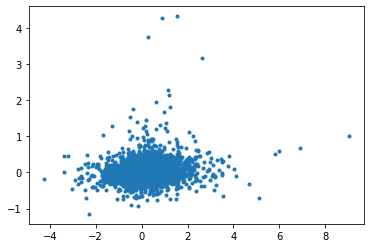

In [216]:
plt.plot(cov2_only['6_GSE147507_Series6_log2_fc'],cov2_only['2_GSE147507_Series2_log2_fc'],'.')
plt.show()